# Step 1: Convert geometry to didgelab format

We got the geomtry in textual format and need to convert it to a Python array.

In [2]:
import sys
sys.path.append('../../')
from didgelab.calc.geo import Geo
from didgelab.app import init_app
import json

init_app() # init the didgelab app

geo_str = """0.0000 0.02894
0.0166 0.02590
0.0499 0.02539
0.0847 0.02505
0.1210 0.02505
0.1557 0.02522
0.1950 0.02691
0.2359 0.02843
0.2752 0.02860
0.3266 0.02843
0.3644 0.03029
0.3901 0.03300
0.4249 0.03790
0.4657 0.04315
0.5005 0.04501
0.5443 0.04467
0.5791 0.04467
0.6124 0.04619
0.6668 0.05059
0.6895 0.05126
0.7333 0.04974
0.7787 0.04687
0.8059 0.04585
0.8437 0.04619
0.8785 0.04721
0.9148 0.04771
0.9616 0.04619
0.9994 0.04551
1.0297 0.04704
1.0750 0.05313
1.1053 0.05904
1.1521 0.06868
1.1930 0.07477
1.2232 0.07765
1.2686 0.07985
1.3049 0.08154
1.3427 0.08357
1.3956 0.08678
1.4304 0.08779
1.4787 0.08746
1.5120 0.08695"""

geo = []
for line in geo_str.split("\n"):
    line = line.split(" ")
    for i in range(len(line)):
        line[i] = float(line[i])*1000
    geo.append(line)
geo = Geo(geo)
json.dump(geo.geo, open("results/original_geo.json", "w"))
print(geo.geo)

2025-04-29 07:18:22,646 [INFO] {app.py:51} output folder: /opt/miniconda3/envs/didge/lib/python3.8/site-packages/didgelab/../../evolutions/2025-04-29T07-18-22_jupyter
2025-04-29 07:18:22,647 [INFO] {app.py:57} Configuration:
log_level: info


[[0.0, 28.94], [16.6, 25.9], [49.9, 25.39], [84.7, 25.05], [121.0, 25.05], [155.70000000000002, 25.22], [195.0, 26.91], [235.9, 28.43], [275.2, 28.6], [326.6, 28.43], [364.4, 30.290000000000003], [390.1, 33.0], [424.9, 37.900000000000006], [465.7, 43.15], [500.49999999999994, 45.01], [544.3, 44.67], [579.0999999999999, 44.67], [612.4000000000001, 46.190000000000005], [666.8, 50.59], [689.5, 51.26], [733.3, 49.74], [778.6999999999999, 46.870000000000005], [805.9, 45.85], [843.7, 46.190000000000005], [878.5, 47.21], [914.8, 47.71], [961.6, 46.190000000000005], [999.4, 45.510000000000005], [1029.7, 47.04], [1075.0, 53.129999999999995], [1105.3, 59.04], [1152.1, 68.68], [1193.0, 74.77000000000001], [1223.2, 77.64999999999999], [1268.6, 79.85000000000001], [1304.8999999999999, 81.54], [1342.7, 83.57000000000001], [1395.6, 86.78], [1430.3999999999999, 87.79], [1478.6999999999998, 87.46], [1512.0, 86.95]]


# Analyze the existing shape

Plot the didge and analyze sonic characteristics. First the didgeridoo form, then the impedance and ground sound spektra, then a table with the resonant peaks of the didge

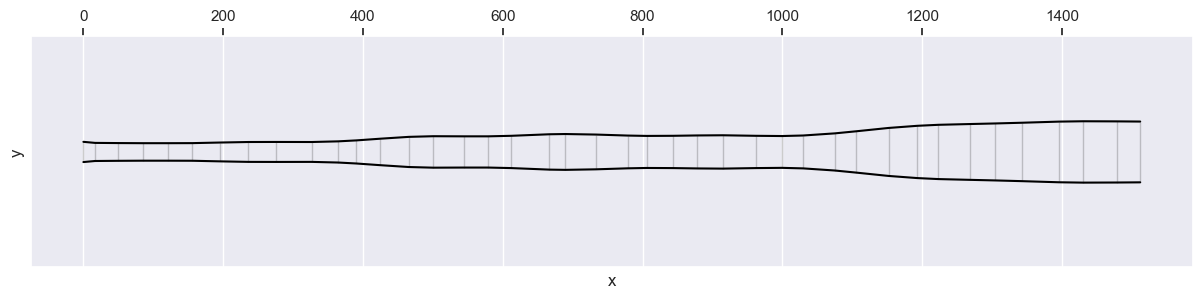

In [5]:
from didgelab.util.didge_visualizer import vis_didge
vis_didge(geo)

The next cell runs an acoustic simulation.

Text(0.5, 1.0, 'Impedance Spektrum')

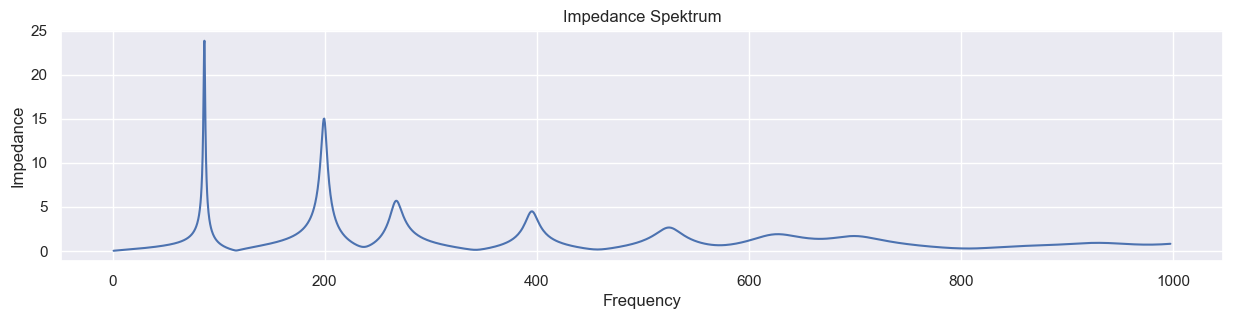

In [6]:
from didgelab.calc.sim.sim import get_notes, compute_impedance, create_segments, get_log_simulation_frequencies
import matplotlib.pyplot as plt

max_error = 5
segments = create_segments(geo)
freqs = get_log_simulation_frequencies(1, 1000, max_error)
impedances = compute_impedance(segments, freqs)

plt.plot(freqs, impedances)
plt.xlabel("Frequency")
plt.ylabel("Impedance")
plt.title("Impedance Spektrum")

Text(0.5, 1.0, 'Ground Tone Spektrum')

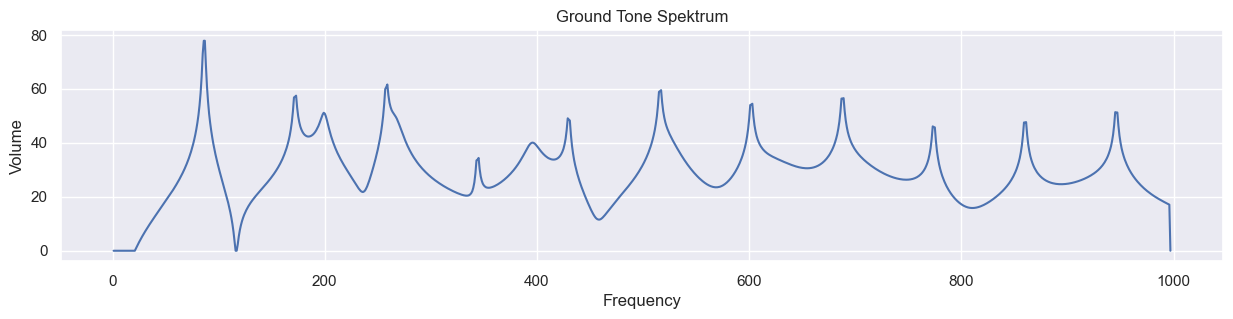

In [7]:
from didgelab.calc.sim.sim import interpolate_spectrum, compute_ground_spektrum

freq_interpolated, impedance_interpolated = interpolate_spectrum(freqs, impedances)
ground_spektrum = compute_ground_spektrum(freq_interpolated, impedance_interpolated)
plt.plot(freq_interpolated, ground_spektrum)
plt.xlabel("Frequency")
plt.ylabel("Volume")
plt.title("Ground Tone Spektrum")

In [8]:
get_notes(freqs, impedances)

,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,F1,-12.631656,-28,86.672355,23.861080,1.000000
1,G2,32.368344,-14,199.696698,15.019920,0.629474
2,C3,37.368344,-9,267.334088,5.685782,0.238287
3,G3,17.368344,-2,395.947864,4.482333,0.187851
4,C4,7.368344,3,525.482897,2.646726,0.110922
5,D#4,12.368344,6,626.715414,1.893428,0.079352
6,F4,2.368344,8,699.412611,1.683944,0.070573
7,A#5,-7.631656,13,928.226666,0.908844,0.038089


Next, define the goal for the evolution

* Maintain peaks
* Shift 2nd peak from G to F#

(-0.5, 1.0)

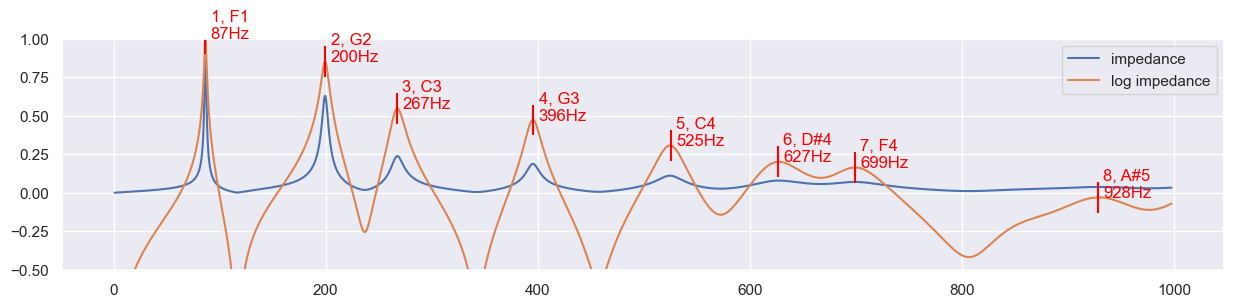

In [9]:
from scipy.signal import find_peaks
from didgelab.calc.conv import freq_to_note, note_name
import numpy as np

# acoustical simulation
log_impedances = np.log2(impedances)
log_impedances /= log_impedances.max()
peaks = find_peaks(log_impedances)
peak_frequencies = [freqs[peak] for peak in peaks[0]]
norm_impedances = impedances / impedances.max()

# plot
plt.plot(freqs, norm_impedances, label="impedance")
plt.plot(freqs, log_impedances, label="log impedance")
for i in range(len(peak_frequencies)):
    freq = peak_frequencies[i]
    note = round(freq_to_note(freq))
    name = note_name(note)
    label = f"{i+1}, {name}\n{round(freq)}Hz"
    y = log_impedances[peaks[0][i]]
    plt.text(freq+5, y, label, color="red")
    plt.vlines(freq, y-0.1, y+0.1, color="red")
plt.legend(loc="upper right")
plt.ylim([-0.5, 1])

Goals:

* maintain resonances of 1, 5, 6, 7 in frequency and amplitude 
* change resonance 2 from G to F#
* We do not care where resonances 3, 4 and 8 go

In [11]:
from didgelab.calc.conv import note_to_freq
import pickle

target_freqs = []
target_impedances = []
for i in range(len(peak_frequencies)):
    freq = np.log2(peak_frequencies[i] / freqs.max())
    target_freqs.append(freq)
    impedance = log_impedances[peaks[0][i]]
    target_impedances.append(impedance)

fsharp = -15
target_freqs[1] = np.log2(note_to_freq(fsharp) / freqs.max())
target_freqs = np.array(target_freqs)
target_impedances = np.array(target_impedances)
target_weights = np.ones(len(target_freqs))

pickle.dump((target_freqs, target_impedances, geo), open("results/targets.bin", "wb"))

print("target_freqs\t", target_freqs.round(2))
print("target_freqs\t", [round(x*freqs.max(), 1) for x in np.power(2, target_freqs)])
print("target_impedances\t", target_impedances.round(2))


target_freqs	 [-3.53 -2.43 -1.9  -1.33 -0.93 -0.67 -0.51 -0.1 ]
target_freqs	 [86.7, 185.0, 267.3, 395.9, 525.5, 626.7, 699.4, 928.2]
target_impedances	 [ 1.    0.85  0.55  0.47  0.31  0.2   0.16 -0.03]


Next, we define the loss function that will guide the evolutionary algorithm to find a didgeridoo shape. The loss function 

$error^2 = \Delta freq^2 + \Delta impedance^2$ 
$error = \sqrt{\Delta freq^2 + \Delta impedance^2}$

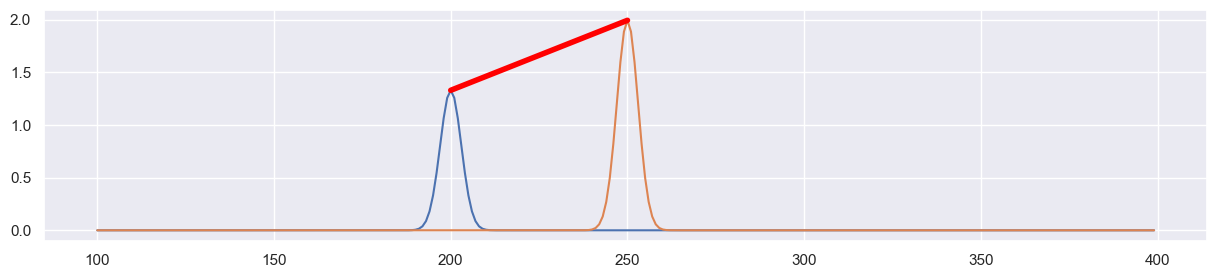

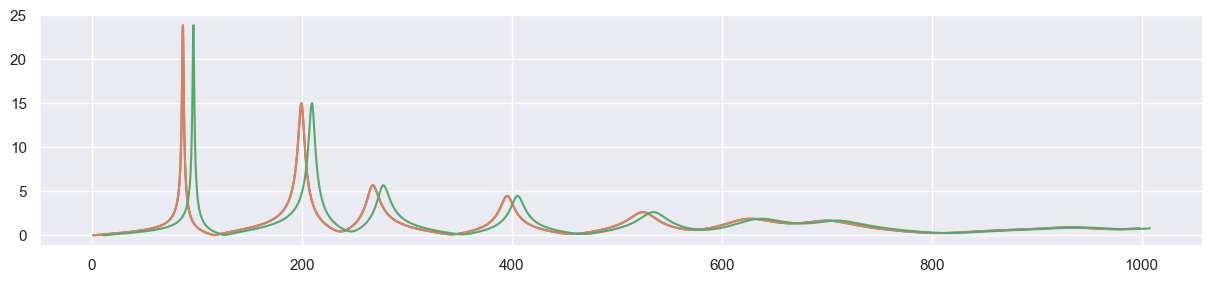

In [8]:
from tairua import PointShape

shape = PointShape(geo)
new_geo = shape.genome2geo()

new_segments = create_segments(new_geo)
new_impedances = compute_impedance(new_segments, freqs)
plt.plot(freqs, impedances, label="original geo")
plt.plot(freqs, new_impedances, label="reconstructed by the point shape")
plt.plot(freqs+10, new_impedances, label="shifted reconstruction")

In [ ]:
from didgelab.evo.nuevolution import Nuevolution, LinearDecreasingMutation, PrintEvolutionInformation, \
    EarlyStopping, NuevolutionProgressBar, SimpleMutation, SingleMutation, RandomCrossover, AverageCrossover, \
    PartAverageCrossover, PartSwapCrossover

from didgelab.app import get_app
import logging

from tairua import TairuaLoss, PointShape

loss = TairuaLoss(target_freqs, target_impedances, target_weights)

init_app()
logging.getLogger().setLevel(logging.WARNING)

evo = Nuevolution(
    loss, 
    PointShape(geo),
    generation_size = 50,
    num_generations = 100,
    population_size = 100,
    evolution_parameters = {
        "mutation_rate": 0.2,
        "gene_mutation_prob": 0.4,
    },
    evolution_operators = [
        RandomCrossover(), 
        AverageCrossover(), 
        SimpleMutation(),
        SingleMutation(),
        PartAverageCrossover(),
        PartSwapCrossover()
    ],
)

schedulers = [
    # LinearDecreasingCrossover(),
    LinearDecreasingMutation()
]

pbi = PrintEvolutionInformation(interval=1)
es = EarlyStopping()

pbar = NuevolutionProgressBar()

def generation_ended(i_generation, population):
    geo = population[0].genome2geo()
    freqs = get_log_simulation_frequencies(1, 1000, max_error)
    segments = create_segments(geo)
    impedances = compute_impedance(segments, freqs)
    notes = get_notes(freqs, impedances)
    print(notes.round(2))

    l = loss.loss(population[0])
    print(f"loss: {l['total']:.2f}")
    if "individual_losses" in l.keys():
        il = np.array(l["individual_losses"])
        print(il.round(2))

get_app().subscribe("generation_ended", generation_ended)
population = evo.evolve()

2025-04-27 22:12:49,557 [INFO] {app.py:51} output folder: /opt/miniconda3/envs/didge/lib/python3.8/site-packages/didgelab/../../evolutions/2025-04-27T22-12-49_jupyter
2025-04-27 22:12:49,558 [INFO] {app.py:57} Configuration:
log_level: info
2025-04-27 22:12:49,558 [INFO] {app.py:141} 
 _____  _     _              _           _     
|  __ \(_)   | |            | |         | |    
| |  | |_  __| | __ _  ___  | |     __ _| |__  
| |  | | |/ _` |/ _` |/ _ \ | |    / _` | '_ \ 
| |__| | | (_| | (_| |  __/ | |___| (_| | |_) |
|_____/|_|\__,_|\__, |\___| |______\__,_|_.__/ 
                 __/ |                         
                |___/                          
Starting /opt/miniconda3/envs/didge/lib/python3.8/site-packages/ipykernel_launcher.py --f=/Users/jannehring/Library/Jupyter/runtime/kernel-v37ebb4e0a699d37f2a025b68e01d9b7cae8549e4b.json
generation=1, best loss=1.82:   1%|          | 1/100 [00:00<00:00, 123361.88it/s]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -12.63      -28   86.67      23.88     1.00
1        G2      32.37      -14  199.70      15.08     0.63
2        C3      37.37       -9  267.33       5.64     0.24
3        G3      12.37       -2  394.81       4.53     0.19
4        C4       7.37        3  525.48       2.63     0.11
5       D#4      12.37        6  626.72       1.90     0.08
6        F4       2.37        8  699.41       1.66     0.07
7       A#5      -2.63       13  930.91       0.89     0.04
loss: 1.82
[0.   0.74 0.31 0.28 0.2  0.12 0.09 0.07]


generation=2, best loss=1.82:   2%|▏         | 2/100 [00:17<14:33,  8.92s/it]    

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -12.63      -28   86.67      23.88     1.00
1        G2      32.37      -14  199.70      15.08     0.63
2        C3      37.37       -9  267.33       5.64     0.24
3        G3      12.37       -2  394.81       4.53     0.19
4        C4       7.37        3  525.48       2.63     0.11
5       D#4      12.37        6  626.72       1.90     0.08
6        F4       2.37        8  699.41       1.66     0.07
7       A#5      -2.63       13  930.91       0.89     0.04
loss: 1.82
[0.   0.74 0.31 0.28 0.2  0.12 0.09 0.07]


generation=3, best loss=1.82:   3%|▎         | 3/100 [00:36<21:06, 13.05s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -12.63      -28   86.67      23.88     1.00
1        G2      32.37      -14  199.70      15.08     0.63
2        C3      37.37       -9  267.33       5.64     0.24
3        G3      12.37       -2  394.81       4.53     0.19
4        C4       7.37        3  525.48       2.63     0.11
5       D#4      12.37        6  626.72       1.90     0.08
6        F4       2.37        8  699.41       1.66     0.07
7       A#5      -2.63       13  930.91       0.89     0.04
loss: 1.82
[0.   0.74 0.31 0.28 0.2  0.12 0.09 0.07]


2025-04-27 22:14:21,896 [ERROR] {tairua.py:88} attempt to get argmin of an empty sequence
generation=4, best loss=1.82:   4%|▍         | 4/100 [00:54<23:37, 14.76s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -12.63      -28   86.67      23.88     1.00
1        G2      32.37      -14  199.70      15.08     0.63
2        C3      37.37       -9  267.33       5.64     0.24
3        G3      12.37       -2  394.81       4.53     0.19
4        C4       7.37        3  525.48       2.63     0.11
5       D#4      12.37        6  626.72       1.90     0.08
6        F4       2.37        8  699.41       1.66     0.07
7       A#5      -2.63       13  930.91       0.89     0.04
loss: 1.82
[0.   0.74 0.31 0.28 0.2  0.12 0.09 0.07]


generation=5, best loss=1.71:   5%|▌         | 5/100 [01:11<24:47, 15.66s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      42.37      -29   84.45      23.46     1.00
1        G2      -7.63      -14  195.14      15.47     0.66
2        C3      17.37       -9  264.26       7.97     0.34
3        G3      22.37       -2  397.09       4.40     0.19
4        C4       2.37        3  523.97       1.65     0.07
5        D4      -2.63        5  586.44       1.43     0.06
6        F4     -37.63        8  683.44       3.62     0.15
7       G#4      12.37       11  836.56       0.94     0.04
8       A#5      47.37       13  958.19       1.70     0.07
loss: 1.71
[0.04 0.63 0.21 0.29 0.24 0.17 0.03 0.11]


generation=6, best loss=1.71:   6%|▌         | 6/100 [01:28<25:21, 16.18s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      42.37      -29   84.45      23.46     1.00
1        G2      -7.63      -14  195.14      15.47     0.66
2        C3      17.37       -9  264.26       7.97     0.34
3        G3      22.37       -2  397.09       4.40     0.19
4        C4       2.37        3  523.97       1.65     0.07
5        D4      -2.63        5  586.44       1.43     0.06
6        F4     -37.63        8  683.44       3.62     0.15
7       G#4      12.37       11  836.56       0.94     0.04
8       A#5      47.37       13  958.19       1.70     0.07
loss: 1.71
[0.04 0.63 0.21 0.29 0.24 0.17 0.03 0.11]


generation=7, best loss=1.39:   7%|▋         | 7/100 [01:46<25:58, 16.76s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      22.37      -29   83.48      22.50     1.00
1        F2      47.37      -16  179.46      17.29     0.77
2        C3       2.37       -9  261.98       2.17     0.10
3        G3      17.37       -2  395.95       7.21     0.32
4        B4     -27.63        2  486.06       6.25     0.28
5        D4      37.37        5  600.14       0.68     0.03
6        F4      22.37        8  707.54       3.03     0.13
7        A5      42.37       12  901.80       1.62     0.07
loss: 1.39
[0.05 0.29 0.45 0.15 0.12 0.18 0.03 0.11]


generation=8, best loss=1.39:   8%|▊         | 8/100 [02:04<26:02, 16.98s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      22.37      -29   83.48      22.50     1.00
1        F2      47.37      -16  179.46      17.29     0.77
2        C3       2.37       -9  261.98       2.17     0.10
3        G3      17.37       -2  395.95       7.21     0.32
4        B4     -27.63        2  486.06       6.25     0.28
5        D4      37.37        5  600.14       0.68     0.03
6        F4      22.37        8  707.54       3.03     0.13
7        A5      42.37       12  901.80       1.62     0.07
loss: 1.39
[0.05 0.29 0.45 0.15 0.12 0.18 0.03 0.11]


generation=9, best loss=1.39:   9%|▉         | 9/100 [02:21<26:00, 17.14s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      22.37      -29   83.48      22.50     1.00
1        F2      47.37      -16  179.46      17.29     0.77
2        C3       2.37       -9  261.98       2.17     0.10
3        G3      17.37       -2  395.95       7.21     0.32
4        B4     -27.63        2  486.06       6.25     0.28
5        D4      37.37        5  600.14       0.68     0.03
6        F4      22.37        8  707.54       3.03     0.13
7        A5      42.37       12  901.80       1.62     0.07
loss: 1.39
[0.05 0.29 0.45 0.15 0.12 0.18 0.03 0.11]


2025-04-27 22:16:09,081 [ERROR] {tairua.py:88} attempt to get argmin of an empty sequence
generation=10, best loss=1.37:  10%|█         | 10/100 [02:39<25:53, 17.26s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      37.37      -29   84.20      21.98     1.00
1        G2     -42.63      -14  191.23      19.99     0.91
2        C3      47.37       -9  268.88       5.59     0.25
3       F#3      32.37       -3  376.98       5.60     0.25
4       C#4     -32.63        4  544.01       3.34     0.15
5        F4      -7.63        8  695.38       4.93     0.22
6       G#4     -12.63       11  824.57       0.47     0.02
7       A#5      47.37       13  958.19       3.93     0.18
loss: 1.37
[0.04 0.22 0.29 0.23 0.16 0.15 0.06 0.21]


2025-04-27 22:16:36,560 [ERROR] {tairua.py:88} attempt to get argmin of an empty sequence
generation=11, best loss=1.18:  11%|█         | 11/100 [02:57<26:04, 17.57s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1     -12.63      -29   81.81      22.15     1.00
1       F#2     -17.63      -15  183.12      18.73     0.85
2        C3     -32.63       -9  256.74       1.70     0.08
3       G#3     -17.63       -1  411.10       9.09     0.41
4        B4     -42.63        2  481.87       5.53     0.25
5        F4      -7.63        8  695.38       2.37     0.11
6        A5      22.37       12  891.44       1.57     0.07
loss: 1.18
[0.08 0.05 0.47 0.08 0.14 0.18 0.06 0.12]


generation=12, best loss=1.15:  12%|█▏        | 12/100 [03:15<25:52, 17.65s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      -2.63      -29   82.28      25.55     1.00
1        F2      47.37      -16  179.46      21.04     0.82
2        C3     -47.63       -9  254.53      18.17     0.71
3       F#3      37.37       -3  378.07       6.05     0.24
4        C4     -37.63        3  512.00       5.82     0.23
5        D4      22.37        5  594.97       1.16     0.05
6        F4     -47.63        8  679.50       2.84     0.11
7       G#4     -32.63       11  815.10       0.36     0.01
8       A#5      12.37       13  939.01       3.28     0.13
loss: 1.15
[0.08 0.16 0.18 0.25 0.09 0.17 0.07 0.16]


generation=13, best loss=1.15:  13%|█▎        | 13/100 [03:33<25:54, 17.87s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      -2.63      -29   82.28      25.55     1.00
1        F2      47.37      -16  179.46      21.04     0.82
2        C3     -47.63       -9  254.53      18.17     0.71
3       F#3      37.37       -3  378.07       6.05     0.24
4        C4     -37.63        3  512.00       5.82     0.23
5        D4      22.37        5  594.97       1.16     0.05
6        F4     -47.63        8  679.50       2.84     0.11
7       G#4     -32.63       11  815.10       0.36     0.01
8       A#5      12.37       13  939.01       3.28     0.13
loss: 1.15
[0.08 0.16 0.18 0.25 0.09 0.17 0.07 0.16]


generation=14, best loss=1.14:  14%|█▍        | 14/100 [03:52<25:45, 17.97s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1     -17.63      -29   81.57      22.33     1.00
1       F#2     -12.63      -15  183.65      19.00     0.85
2        C3     -32.63       -9  256.74       1.60     0.07
3       G#3     -17.63       -1  411.10       9.80     0.44
4        B4     -37.63        2  483.26       5.57     0.25
5        F4     -12.63        8  693.38       2.48     0.11
6        A5      12.37       12  886.31       1.44     0.06
loss: 1.14
[0.09 0.03 0.48 0.06 0.13 0.17 0.05 0.12]


generation=15, best loss=1.13:  15%|█▌        | 15/100 [04:09<25:15, 17.83s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0       D#1      47.37      -30   79.94      22.65     1.00
1        F2      42.37      -16  178.94      20.71     0.91
2        C3      -7.63       -9  260.47       8.98     0.40
3       F#3      -2.63       -3  369.43       6.19     0.27
4        B4      22.37        2  500.31       4.21     0.19
5        E4     -22.63        7  650.69       4.93     0.22
6        G4     -17.63       10  776.05       0.49     0.02
7        A5       7.37       12  883.75       0.66     0.03
loss: 1.13
[0.12 0.23 0.16 0.22 0.14 0.06 0.12 0.09]


generation=16, best loss=0.94:  16%|█▌        | 16/100 [04:28<25:19, 18.09s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1      -7.63      -28   86.92      26.62     1.00
1       F#2      47.37      -15  190.13      21.35     0.80
2        C3      -2.63       -9  261.23       7.82     0.29
3        G3      -2.63       -2  391.40       9.63     0.36
4        C4     -37.63        3  512.00       7.80     0.29
5        D4      47.37        5  603.62       2.56     0.10
6        F4      17.37        8  705.50       1.42     0.05
7        A5     -32.63       12  863.57       0.47     0.02
8        B5     -17.63       14  977.76       0.90     0.03
loss: 0.94
[0.   0.2  0.26 0.11 0.04 0.12 0.11 0.1 ]


generation=17, best loss=0.94:  17%|█▋        | 17/100 [04:46<25:11, 18.21s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1      -7.63      -28   86.92      26.62     1.00
1       F#2      47.37      -15  190.13      21.35     0.80
2        C3      -2.63       -9  261.23       7.82     0.29
3        G3      -2.63       -2  391.40       9.63     0.36
4        C4     -37.63        3  512.00       7.80     0.29
5        D4      47.37        5  603.62       2.56     0.10
6        F4      17.37        8  705.50       1.42     0.05
7        A5     -32.63       12  863.57       0.47     0.02
8        B5     -17.63       14  977.76       0.90     0.03
loss: 0.94
[0.   0.2  0.26 0.11 0.04 0.12 0.11 0.1 ]


generation=18, best loss=0.90:  18%|█▊        | 18/100 [05:04<24:38, 18.03s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1      -7.63      -28   86.92      26.44     1.00
1       F#2      47.37      -15  190.13      21.69     0.82
2        C3       2.37       -9  261.98       7.55     0.29
3        G3      -7.63       -2  390.27      10.04     0.38
4        C4     -32.63        3  513.48       7.63     0.29
5        D4      42.37        5  601.88       2.58     0.10
6        F4      27.37        8  709.59       1.38     0.05
7        A5     -42.63       12  858.59       0.49     0.02
8        B5      -7.63       14  983.42       0.94     0.04
loss: 0.90
[0.   0.16 0.26 0.1  0.04 0.12 0.11 0.11]


generation=19, best loss=0.88:  19%|█▉        | 19/100 [05:21<24:04, 17.83s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -22.63      -28   86.17      25.70     1.00
1        G2     -37.63      -14  191.78      21.38     0.83
2        C3       2.37       -9  261.98       7.32     0.28
3        G3     -32.63       -2  384.68      11.21     0.44
4        C4      -7.63        3  520.95       5.67     0.22
5       D#4     -27.63        6  612.40       1.94     0.08
6        F4      47.37        8  717.83       2.63     0.10
7       G#4      32.37       11  846.29       1.16     0.05
8        B5     -27.63       14  972.13       0.90     0.03
loss: 0.88
[0.01 0.17 0.26 0.06 0.09 0.13 0.07 0.09]


2025-04-27 22:19:07,168 [ERROR] {tairua.py:88} attempt to get argmin of an empty sequence
generation=20, best loss=0.81:  20%|██        | 20/100 [05:40<23:59, 17.99s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1       7.37      -29   82.76      22.62     1.00
1       F#2      27.37      -15  187.94      19.48     0.86
2        C3      12.37       -9  263.50       9.78     0.43
3        G3      27.37       -2  398.24       9.05     0.40
4        C4      37.37        3  534.67       2.20     0.10
5        F4     -42.63        8  681.47       4.45     0.20
6        G4      32.37       10  798.79       2.18     0.10
7        A5      37.37       12  899.20       1.42     0.06
loss: 0.81
[0.07 0.07 0.12 0.07 0.21 0.12 0.05 0.1 ]


generation=21, best loss=0.81:  21%|██        | 21/100 [05:58<23:45, 18.05s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1       7.37      -29   82.76      22.62     1.00
1       F#2      27.37      -15  187.94      19.48     0.86
2        C3      12.37       -9  263.50       9.78     0.43
3        G3      27.37       -2  398.24       9.05     0.40
4        C4      37.37        3  534.67       2.20     0.10
5        F4     -42.63        8  681.47       4.45     0.20
6        G4      32.37       10  798.79       2.18     0.10
7        A5      37.37       12  899.20       1.42     0.06
loss: 0.81
[0.07 0.07 0.12 0.07 0.21 0.12 0.05 0.1 ]


generation=22, best loss=0.78:  22%|██▏       | 22/100 [06:15<23:10, 17.82s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      32.37      -29   83.96      24.97     1.00
1       F#2       7.37      -15  185.79      20.47     0.82
2        C3      -7.63       -9  260.47      14.23     0.57
3        G3      -7.63       -2  390.27       7.44     0.30
4        C4      -2.63        3  522.46       3.77     0.15
5       D#4     -37.63        6  608.87       2.71     0.11
6        F4     -32.63        8  685.41       2.59     0.10
7        A5     -42.63       12  858.59       0.90     0.04
8       A#5      32.37       13  949.92       1.34     0.05
loss: 0.78
[0.05 0.1  0.04 0.18 0.16 0.1  0.07 0.09]


generation=23, best loss=0.78:  23%|██▎       | 23/100 [06:34<23:09, 18.05s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      32.37      -29   83.96      24.97     1.00
1       F#2       7.37      -15  185.79      20.47     0.82
2        C3      -7.63       -9  260.47      14.23     0.57
3        G3      -7.63       -2  390.27       7.44     0.30
4        C4      -2.63        3  522.46       3.77     0.15
5       D#4     -37.63        6  608.87       2.71     0.11
6        F4     -32.63        8  685.41       2.59     0.10
7        A5     -42.63       12  858.59       0.90     0.04
8       A#5      32.37       13  949.92       1.34     0.05
loss: 0.78
[0.05 0.1  0.04 0.18 0.16 0.1  0.07 0.09]


generation=24, best loss=0.72:  24%|██▍       | 24/100 [07:23<34:36, 27.32s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      37.37      -29   84.20      24.93     1.00
1       F#2      -2.63      -15  184.72      22.86     0.92
2        C3     -27.63       -9  257.48      14.43     0.58
3        G3      37.37       -2  400.55      11.29     0.45
4        C4      -7.63        3  520.95       5.14     0.21
5       D#4     -22.63        6  614.17       1.59     0.06
6        F4      42.37        8  715.76       2.47     0.10
7        A5      32.37       12  896.61       1.10     0.04
loss: 0.72
[0.04 0.19 0.06 0.03 0.1  0.14 0.07 0.09]


generation=25, best loss=0.68:  25%|██▌       | 25/100 [22:44<6:09:31, 295.63s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      42.37      -29   84.45      23.80     1.00
1       F#2       7.37      -15  185.79      19.61     0.82
2        C3      -7.63       -9  260.47      12.80     0.54
3        G3      17.37       -2  395.95       9.38     0.39
4        C4      32.37        3  533.13       6.66     0.28
5       D#4      37.37        6  635.83       1.07     0.05
6       F#4     -32.63        9  726.17       0.87     0.04
7       A#5     -12.63       13  925.55       1.62     0.07
loss: 0.68
[0.04 0.09 0.04 0.08 0.03 0.16 0.14 0.1 ]


generation=26, best loss=0.68:  26%|██▌       | 26/100 [58:10<17:21:53, 844.78s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      47.37      -29   84.69      24.12     1.00
1       F#2      22.37      -15  187.40      20.35     0.84
2        C3       7.37       -9  262.74      12.71     0.53
3       F#3      47.37       -3  380.26       7.26     0.30
4        C4      37.37        3  534.67       7.89     0.33
5        E4     -37.63        7  645.08       1.39     0.06
6        F4       2.37        8  699.41       1.48     0.06
7       A#5     -37.63       13  912.28       1.09     0.05
loss: 0.68
[0.03 0.06 0.03 0.18 0.03 0.15 0.1  0.08]


generation=27, best loss=0.68:  27%|██▋       | 27/100 [1:14:53<18:05:28, 892.17s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      47.37      -29   84.69      24.12     1.00
1       F#2      22.37      -15  187.40      20.35     0.84
2        C3       7.37       -9  262.74      12.71     0.53
3       F#3      47.37       -3  380.26       7.26     0.30
4        C4      37.37        3  534.67       7.89     0.33
5        E4     -37.63        7  645.08       1.39     0.06
6        F4       2.37        8  699.41       1.48     0.06
7       A#5     -37.63       13  912.28       1.09     0.05
loss: 0.68
[0.03 0.06 0.03 0.18 0.03 0.15 0.1  0.08]


generation=28, best loss=0.60:  28%|██▊       | 28/100 [1:15:11<12:35:51, 629.88s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -47.63      -28   84.94      24.83     1.00
1       F#2       2.37      -15  185.25      20.66     0.83
2        C3     -37.63       -9  256.00      12.01     0.48
3        G3      -2.63       -2  391.40       9.49     0.38
4        C4       7.37        3  525.48       6.85     0.28
5       D#4      27.37        6  632.17       2.48     0.10
6       F#4     -37.63        9  724.08       1.20     0.05
7        A5      42.37       12  901.80       0.59     0.02
loss: 0.60
[0.03 0.07 0.09 0.09 0.03 0.1  0.13 0.07]


generation=29, best loss=0.60:  29%|██▉       | 29/100 [1:30:29<14:07:42, 716.37s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -47.63      -28   84.94      24.83     1.00
1       F#2       2.37      -15  185.25      20.66     0.83
2        C3     -37.63       -9  256.00      12.01     0.48
3        G3      -2.63       -2  391.40       9.49     0.38
4        C4       7.37        3  525.48       6.85     0.28
5       D#4      27.37        6  632.17       2.48     0.10
6       F#4     -37.63        9  724.08       1.20     0.05
7        A5      42.37       12  901.80       0.59     0.02
loss: 0.60
[0.03 0.07 0.09 0.09 0.03 0.1  0.13 0.07]


generation=30, best loss=0.60:  30%|███       | 30/100 [1:48:24<16:01:22, 824.03s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -47.63      -28   84.94      24.83     1.00
1       F#2       2.37      -15  185.25      20.66     0.83
2        C3     -37.63       -9  256.00      12.01     0.48
3        G3      -2.63       -2  391.40       9.49     0.38
4        C4       7.37        3  525.48       6.85     0.28
5       D#4      27.37        6  632.17       2.48     0.10
6       F#4     -37.63        9  724.08       1.20     0.05
7        A5      42.37       12  901.80       0.59     0.02
loss: 0.60
[0.03 0.07 0.09 0.09 0.03 0.1  0.13 0.07]


generation=31, best loss=0.60:  31%|███       | 31/100 [2:03:43<16:20:12, 852.36s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      37.37      -29   84.20      25.18     1.00
1       F#2      -2.63      -15  184.72      21.93     0.87
2        C3     -27.63       -9  257.48      14.35     0.57
3        G3      27.37       -2  398.24       9.31     0.37
4        C4      12.37        3  527.00       5.93     0.24
5       D#4     -12.63        6  617.73       1.70     0.07
6        F4      32.37        8  711.64       2.36     0.09
7       A#5      -7.63       13  928.23       0.92     0.04
loss: 0.60
[0.04 0.05 0.06 0.1  0.07 0.14 0.08 0.07]


generation=32, best loss=0.55:  32%|███▏      | 32/100 [2:07:41<12:37:08, 668.06s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.58     1.00
1       F#2       7.37      -15  185.79      21.79     0.85
2        C3     -17.63       -9  258.97      13.05     0.51
3        G3      47.37       -2  402.87      11.42     0.45
4        C4     -12.63        3  519.45       8.05     0.31
5       D#4      -7.63        6  619.52       0.57     0.02
6        F4      27.37        8  709.59       1.71     0.07
7       G#4     -42.63       11  810.41       0.62     0.02
8        A5      47.37       12  904.41       2.11     0.08
loss: 0.55
[0.02 0.02 0.06 0.04 0.02 0.18 0.1  0.12]


generation=33, best loss=0.55:  33%|███▎      | 33/100 [2:23:00<13:50:13, 743.48s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.58     1.00
1       F#2       7.37      -15  185.79      21.79     0.85
2        C3     -17.63       -9  258.97      13.05     0.51
3        G3      47.37       -2  402.87      11.42     0.45
4        C4     -12.63        3  519.45       8.05     0.31
5       D#4      -7.63        6  619.52       0.57     0.02
6        F4      27.37        8  709.59       1.71     0.07
7       G#4     -42.63       11  810.41       0.62     0.02
8        A5      47.37       12  904.41       2.11     0.08
loss: 0.55
[0.02 0.02 0.06 0.04 0.02 0.18 0.1  0.12]


generation=34, best loss=0.55:  34%|███▍      | 34/100 [2:38:18<14:35:26, 795.85s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.58     1.00
1       F#2       7.37      -15  185.79      21.79     0.85
2        C3     -17.63       -9  258.97      13.05     0.51
3        G3      47.37       -2  402.87      11.42     0.45
4        C4     -12.63        3  519.45       8.05     0.31
5       D#4      -7.63        6  619.52       0.57     0.02
6        F4      27.37        8  709.59       1.71     0.07
7       G#4     -42.63       11  810.41       0.62     0.02
8        A5      47.37       12  904.41       2.11     0.08
loss: 0.55
[0.02 0.02 0.06 0.04 0.02 0.18 0.1  0.12]


generation=35, best loss=0.55:  35%|███▌      | 35/100 [3:09:29<20:11:41, 1118.48s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.73     1.00
1       F#2      -2.63      -15  184.72      22.12     0.86
2        C3     -22.63       -9  258.23      13.83     0.54
3        G3      47.37       -2  402.87      12.35     0.48
4        C4     -12.63        3  519.45       9.16     0.36
5       D#4      22.37        6  630.35       0.69     0.03
6        F4      47.37        8  717.83       1.65     0.06
7       G#4       2.37       11  831.75       0.55     0.02
8        A5      47.37       12  904.41       1.59     0.06
loss: 0.55
[0.03 0.02 0.05 0.03 0.05 0.17 0.11 0.1 ]


generation=36, best loss=0.55:  36%|███▌      | 36/100 [3:24:49<18:49:16, 1058.70s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.73     1.00
1       F#2      -2.63      -15  184.72      22.12     0.86
2        C3     -22.63       -9  258.23      13.83     0.54
3        G3      47.37       -2  402.87      12.35     0.48
4        C4     -12.63        3  519.45       9.16     0.36
5       D#4      22.37        6  630.35       0.69     0.03
6        F4      47.37        8  717.83       1.65     0.06
7       G#4       2.37       11  831.75       0.55     0.02
8        A5      47.37       12  904.41       1.59     0.06
loss: 0.55
[0.03 0.02 0.05 0.03 0.05 0.17 0.11 0.1 ]


generation=37, best loss=0.55:  37%|███▋      | 37/100 [3:42:20<18:29:23, 1056.57s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.73     1.00
1       F#2       7.37      -15  185.79      21.84     0.85
2        C3     -17.63       -9  258.97      13.07     0.51
3       G#3     -47.63       -1  404.03      11.61     0.45
4        C4     -12.63        3  519.45       7.73     0.30
5       D#4      -7.63        6  619.52       0.60     0.02
6        F4      27.37        8  709.59       1.60     0.06
7       G#4     -42.63       11  810.41       0.67     0.03
8        A5      47.37       12  904.41       1.95     0.08
loss: 0.55
[0.02 0.02 0.06 0.04 0.02 0.18 0.1  0.11]


generation=38, best loss=0.54:  38%|███▊      | 38/100 [3:42:38<12:49:52, 745.04s/it] 

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.56     1.00
1       F#2       2.37      -15  185.25      21.81     0.85
2        C3     -17.63       -9  258.97      13.00     0.51
3        G3      47.37       -2  402.87      11.44     0.45
4        C4     -12.63        3  519.45       8.17     0.32
5       D#4     -12.63        6  617.73       0.56     0.02
6        F4      27.37        8  709.59       1.75     0.07
7       G#4     -42.63       11  810.41       0.60     0.02
8        A5      47.37       12  904.41       2.17     0.08
loss: 0.54
[0.02 0.01 0.06 0.04 0.02 0.18 0.1  0.12]


generation=39, best loss=0.52:  39%|███▉      | 39/100 [3:57:58<13:30:39, 797.37s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.50     1.00
1       F#2      17.37      -15  186.86      21.51     0.84
2        C3       2.37       -9  261.98      13.93     0.55
3        G3      17.37       -2  395.95      11.17     0.44
4        C4      32.37        3  533.13       7.73     0.30
5       D#4       7.37        6  624.91       1.49     0.06
6        F4      37.37        8  713.70       1.28     0.05
7       A#5       2.37       13  933.60       1.82     0.07
loss: 0.52
[0.02 0.05 0.03 0.03 0.02 0.14 0.12 0.1 ]


generation=40, best loss=0.48:  40%|████      | 40/100 [4:13:21<13:55:07, 835.12s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.40     1.00
1       F#2       7.37      -15  185.79      21.72     0.85
2        C3       2.37       -9  261.98      14.98     0.59
3        G3      12.37       -2  394.81      12.13     0.48
4        C4      37.37        3  534.67       8.22     0.32
5       D#4      12.37        6  626.72       1.66     0.07
6        F4      37.37        8  713.70       1.26     0.05
7       A#5       7.37       13  936.30       1.70     0.07
loss: 0.48
[0.02 0.02 0.05 0.01 0.03 0.14 0.12 0.1 ]


generation=41, best loss=0.48:  41%|████      | 41/100 [4:43:46<18:33:12, 1132.07s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.40     1.00
1       F#2       7.37      -15  185.79      21.72     0.85
2        C3       2.37       -9  261.98      14.98     0.59
3        G3      12.37       -2  394.81      12.13     0.48
4        C4      37.37        3  534.67       8.22     0.32
5       D#4      12.37        6  626.72       1.66     0.07
6        F4      37.37        8  713.70       1.26     0.05
7       A#5       7.37       13  936.30       1.70     0.07
loss: 0.48
[0.02 0.02 0.05 0.01 0.03 0.14 0.12 0.1 ]


generation=42, best loss=0.48:  42%|████▏     | 42/100 [5:01:20<17:51:45, 1108.71s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.40     1.00
1       F#2       7.37      -15  185.79      21.72     0.85
2        C3       2.37       -9  261.98      14.98     0.59
3        G3      12.37       -2  394.81      12.13     0.48
4        C4      37.37        3  534.67       8.22     0.32
5       D#4      12.37        6  626.72       1.66     0.07
6        F4      37.37        8  713.70       1.26     0.05
7       A#5       7.37       13  936.30       1.70     0.07
loss: 0.48
[0.02 0.02 0.05 0.01 0.03 0.14 0.12 0.1 ]


2025-04-28 03:15:18,027 [ERROR] {tairua.py:88} attempt to get argmin of an empty sequence
generation=43, best loss=0.47:  43%|████▎     | 43/100 [5:16:39<16:39:04, 1051.65s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      37.37      -29   84.20      24.19     1.00
1       F#2      12.37      -15  186.32      20.68     0.85
2        C3      -2.63       -9  261.23      14.47     0.60
3        G3       7.37       -2  393.67      11.49     0.48
4        C4      37.37        3  534.67       6.70     0.28
5       D#4      47.37        6  639.51       1.61     0.07
6        F4      37.37        8  713.70       2.09     0.09
7       A#5     -17.63       13  922.88       0.80     0.03
loss: 0.47
[0.04 0.03 0.06 0.01 0.04 0.14 0.08 0.06]


generation=44, best loss=0.47:  44%|████▍     | 44/100 [5:46:57<19:56:14, 1281.68s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      37.37      -29   84.20      24.19     1.00
1       F#2      12.37      -15  186.32      20.68     0.85
2        C3      -2.63       -9  261.23      14.47     0.60
3        G3       7.37       -2  393.67      11.49     0.48
4        C4      37.37        3  534.67       6.70     0.28
5       D#4      47.37        6  639.51       1.61     0.07
6        F4      37.37        8  713.70       2.09     0.09
7       A#5     -17.63       13  922.88       0.80     0.03
loss: 0.47
[0.04 0.03 0.06 0.01 0.04 0.14 0.08 0.06]


generation=45, best loss=0.47:  45%|████▌     | 45/100 [6:03:39<18:17:50, 1197.64s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      37.37      -29   84.20      24.19     1.00
1       F#2      12.37      -15  186.32      20.68     0.85
2        C3      -2.63       -9  261.23      14.47     0.60
3        G3       7.37       -2  393.67      11.49     0.48
4        C4      37.37        3  534.67       6.70     0.28
5       D#4      47.37        6  639.51       1.61     0.07
6        F4      37.37        8  713.70       2.09     0.09
7       A#5     -17.63       13  922.88       0.80     0.03
loss: 0.47
[0.04 0.03 0.06 0.01 0.04 0.14 0.08 0.06]


generation=46, best loss=0.47:  46%|████▌     | 46/100 [6:03:57<12:39:20, 843.71s/it] 

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      37.37      -29   84.20      24.19     1.00
1       F#2      12.37      -15  186.32      20.68     0.85
2        C3      -2.63       -9  261.23      14.47     0.60
3        G3       7.37       -2  393.67      11.49     0.48
4        C4      37.37        3  534.67       6.70     0.28
5       D#4      47.37        6  639.51       1.61     0.07
6        F4      37.37        8  713.70       2.09     0.09
7       A#5     -17.63       13  922.88       0.80     0.03
loss: 0.47
[0.04 0.03 0.06 0.01 0.04 0.14 0.08 0.06]


generation=47, best loss=0.47:  47%|████▋     | 47/100 [6:20:25<13:03:43, 887.23s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      37.37      -29   84.20      24.19     1.00
1       F#2      12.37      -15  186.32      20.68     0.85
2        C3      -2.63       -9  261.23      14.47     0.60
3        G3       7.37       -2  393.67      11.49     0.48
4        C4      37.37        3  534.67       6.70     0.28
5       D#4      47.37        6  639.51       1.61     0.07
6        F4      37.37        8  713.70       2.09     0.09
7       A#5     -17.63       13  922.88       0.80     0.03
loss: 0.47
[0.04 0.03 0.06 0.01 0.04 0.14 0.08 0.06]


generation=48, best loss=0.47:  48%|████▊     | 48/100 [6:35:47<12:57:49, 897.49s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      37.37      -29   84.20      24.19     1.00
1       F#2      12.37      -15  186.32      20.68     0.85
2        C3      -2.63       -9  261.23      14.47     0.60
3        G3       7.37       -2  393.67      11.49     0.48
4        C4      37.37        3  534.67       6.70     0.28
5       D#4      47.37        6  639.51       1.61     0.07
6        F4      37.37        8  713.70       2.09     0.09
7       A#5     -17.63       13  922.88       0.80     0.03
loss: 0.47
[0.04 0.03 0.06 0.01 0.04 0.14 0.08 0.06]


generation=49, best loss=0.46:  49%|████▉     | 49/100 [6:51:05<12:48:12, 903.77s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      47.37      -29   84.69      24.22     1.00
1       F#2       2.37      -15  185.25      20.70     0.85
2        C3     -17.63       -9  258.97      13.56     0.56
3        G3      17.37       -2  395.95      11.24     0.46
4        C4      27.37        3  531.59       6.73     0.28
5        E4     -42.63        7  643.22       1.48     0.06
6        F4      22.37        8  707.54       1.75     0.07
7       A#5     -42.63       13  909.65       1.33     0.06
loss: 0.46
[0.03 0.01 0.05 0.01 0.03 0.15 0.09 0.09]


generation=50, best loss=0.44:  50%|█████     | 50/100 [7:21:35<16:24:43, 1181.67s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      42.37      -29   84.45      24.43     1.00
1       F#2       7.37      -15  185.79      21.00     0.86
2        C3      -2.63       -9  261.23      13.75     0.56
3        G3      12.37       -2  394.81      12.14     0.50
4        C4      27.37        3  531.59       6.69     0.27
5        E4     -47.63        7  641.36       1.40     0.06
6        F4      42.37        8  715.76       2.46     0.10
7       A#5     -22.63       13  920.22       0.61     0.03
loss: 0.44
[0.04 0.02 0.04 0.02 0.04 0.15 0.07 0.06]


generation=51, best loss=0.44:  51%|█████     | 51/100 [8:02:54<21:22:43, 1570.68s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        E1      42.37      -29   84.45      24.43     1.00
1       F#2       7.37      -15  185.79      21.00     0.86
2        C3      -2.63       -9  261.23      13.75     0.56
3        G3      12.37       -2  394.81      12.14     0.50
4        C4      27.37        3  531.59       6.69     0.27
5        E4     -47.63        7  641.36       1.40     0.06
6        F4      42.37        8  715.76       2.46     0.10
7       A#5     -22.63       13  920.22       0.61     0.03
loss: 0.44
[0.04 0.02 0.04 0.02 0.04 0.15 0.07 0.06]


generation=52, best loss=0.44:  52%|█████▏    | 52/100 [8:21:26<19:06:37, 1433.27s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.27     1.00
1       F#2      -2.63      -15  184.72      21.49     0.85
2        C3      -7.63       -9  260.47      14.69     0.58
3        G3     -12.63       -2  389.15      12.74     0.50
4        C4      17.37        3  528.53       7.18     0.28
5       D#4      32.37        6  634.00       1.62     0.06
6        F4      32.37        8  711.64       1.98     0.08
7       A#5     -17.63       13  922.88       0.61     0.02
loss: 0.44
[0.03 0.01 0.05 0.04 0.02 0.14 0.09 0.06]


generation=53, best loss=0.44:  53%|█████▎    | 53/100 [8:37:44<16:55:38, 1296.57s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.27     1.00
1       F#2      -2.63      -15  184.72      21.49     0.85
2        C3      -7.63       -9  260.47      14.69     0.58
3        G3     -12.63       -2  389.15      12.74     0.50
4        C4      17.37        3  528.53       7.18     0.28
5       D#4      32.37        6  634.00       1.62     0.06
6        F4      32.37        8  711.64       1.98     0.08
7       A#5     -17.63       13  922.88       0.61     0.02
loss: 0.44
[0.03 0.01 0.05 0.04 0.02 0.14 0.09 0.06]


generation=54, best loss=0.44:  54%|█████▍    | 54/100 [8:38:02<11:40:02, 913.09s/it] 

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.27     1.00
1       F#2      -2.63      -15  184.72      21.49     0.85
2        C3      -7.63       -9  260.47      14.69     0.58
3        G3     -12.63       -2  389.15      12.74     0.50
4        C4      17.37        3  528.53       7.18     0.28
5       D#4      32.37        6  634.00       1.62     0.06
6        F4      32.37        8  711.64       1.98     0.08
7       A#5     -17.63       13  922.88       0.61     0.02
loss: 0.44
[0.03 0.01 0.05 0.04 0.02 0.14 0.09 0.06]


generation=55, best loss=0.44:  55%|█████▌    | 55/100 [8:53:22<11:26:18, 915.09s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.27     1.00
1       F#2      -2.63      -15  184.72      21.49     0.85
2        C3      -7.63       -9  260.47      14.69     0.58
3        G3     -12.63       -2  389.15      12.74     0.50
4        C4      17.37        3  528.53       7.18     0.28
5       D#4      32.37        6  634.00       1.62     0.06
6        F4      32.37        8  711.64       1.98     0.08
7       A#5     -17.63       13  922.88       0.61     0.02
loss: 0.44
[0.03 0.01 0.05 0.04 0.02 0.14 0.09 0.06]


generation=56, best loss=0.43:  56%|█████▌    | 56/100 [9:07:16<10:53:17, 890.86s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.07     1.00
1       F#2      -2.63      -15  184.72      21.42     0.85
2        C3      -7.63       -9  260.47      14.54     0.58
3        G3     -12.63       -2  389.15      12.67     0.51
4        C4      22.37        3  530.06       7.20     0.29
5       D#4      32.37        6  634.00       1.59     0.06
6        F4      37.37        8  713.70       2.00     0.08
7       A#5     -12.63       13  925.55       0.60     0.02
loss: 0.43
[0.03 0.01 0.05 0.04 0.02 0.14 0.09 0.05]


generation=57, best loss=0.43:  57%|█████▋    | 57/100 [9:07:35<7:30:49, 629.05s/it] 

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.07     1.00
1       F#2      -2.63      -15  184.72      21.42     0.85
2        C3      -7.63       -9  260.47      14.54     0.58
3        G3     -12.63       -2  389.15      12.67     0.51
4        C4      22.37        3  530.06       7.20     0.29
5       D#4      32.37        6  634.00       1.59     0.06
6        F4      37.37        8  713.70       2.00     0.08
7       A#5     -12.63       13  925.55       0.60     0.02
loss: 0.43
[0.03 0.01 0.05 0.04 0.02 0.14 0.09 0.05]


generation=58, best loss=0.43:  58%|█████▊    | 58/100 [9:22:54<8:21:21, 716.23s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.07     1.00
1       F#2      -2.63      -15  184.72      21.42     0.85
2        C3      -7.63       -9  260.47      14.54     0.58
3        G3     -12.63       -2  389.15      12.67     0.51
4        C4      22.37        3  530.06       7.20     0.29
5       D#4      32.37        6  634.00       1.59     0.06
6        F4      37.37        8  713.70       2.00     0.08
7       A#5     -12.63       13  925.55       0.60     0.02
loss: 0.43
[0.03 0.01 0.05 0.04 0.02 0.14 0.09 0.05]


generation=59, best loss=0.43:  59%|█████▉    | 59/100 [9:40:44<9:21:51, 822.24s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.07     1.00
1       F#2      -2.63      -15  184.72      21.42     0.85
2        C3      -7.63       -9  260.47      14.54     0.58
3        G3     -12.63       -2  389.15      12.67     0.51
4        C4      22.37        3  530.06       7.20     0.29
5       D#4      32.37        6  634.00       1.59     0.06
6        F4      37.37        8  713.70       2.00     0.08
7       A#5     -12.63       13  925.55       0.60     0.02
loss: 0.43
[0.03 0.01 0.05 0.04 0.02 0.14 0.09 0.05]


generation=60, best loss=0.43:  60%|██████    | 60/100 [9:41:02<6:27:21, 581.04s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.07     1.00
1       F#2      -2.63      -15  184.72      21.42     0.85
2        C3      -7.63       -9  260.47      14.54     0.58
3        G3     -12.63       -2  389.15      12.67     0.51
4        C4      22.37        3  530.06       7.20     0.29
5       D#4      32.37        6  634.00       1.59     0.06
6        F4      37.37        8  713.70       2.00     0.08
7       A#5     -12.63       13  925.55       0.60     0.02
loss: 0.43
[0.03 0.01 0.05 0.04 0.02 0.14 0.09 0.05]


generation=61, best loss=0.43:  61%|██████    | 61/100 [10:01:06<8:19:09, 767.94s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.07     1.00
1       F#2      -2.63      -15  184.72      21.42     0.85
2        C3      -7.63       -9  260.47      14.54     0.58
3        G3     -12.63       -2  389.15      12.67     0.51
4        C4      22.37        3  530.06       7.20     0.29
5       D#4      32.37        6  634.00       1.59     0.06
6        F4      37.37        8  713.70       2.00     0.08
7       A#5     -12.63       13  925.55       0.60     0.02
loss: 0.43
[0.03 0.01 0.05 0.04 0.02 0.14 0.09 0.05]


generation=62, best loss=0.42:  62%|██████▏   | 62/100 [10:24:36<10:08:24, 960.64s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.10     1.00
1       F#2       2.37      -15  185.25      21.49     0.86
2        C3       2.37       -9  261.98      13.96     0.56
3        G3      -7.63       -2  390.27      12.65     0.50
4        C4      17.37        3  528.53       6.77     0.27
5       D#4      37.37        6  635.83       1.55     0.06
6        F4      32.37        8  711.64       2.09     0.08
7       A#5     -17.63       13  922.88       0.68     0.03
loss: 0.42
[0.03 0.01 0.03 0.04 0.04 0.14 0.08 0.06]


generation=63, best loss=0.42:  63%|██████▎   | 63/100 [10:24:55<6:58:03, 677.94s/it] 

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.10     1.00
1       F#2       2.37      -15  185.25      21.49     0.86
2        C3       2.37       -9  261.98      13.96     0.56
3        G3      -7.63       -2  390.27      12.65     0.50
4        C4      17.37        3  528.53       6.77     0.27
5       D#4      37.37        6  635.83       1.55     0.06
6        F4      32.37        8  711.64       2.09     0.08
7       A#5     -17.63       13  922.88       0.68     0.03
loss: 0.42
[0.03 0.01 0.03 0.04 0.04 0.14 0.08 0.06]


generation=64, best loss=0.42:  64%|██████▍   | 64/100 [10:57:52<10:40:40, 1067.79s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -47.63      -28   84.94      24.83     1.00
1       F#2      12.37      -15  186.32      21.22     0.85
2        C3      -2.63       -9  261.23      13.46     0.54
3        G3      12.37       -2  394.81      12.05     0.49
4        C4      22.37        3  530.06       6.63     0.27
5       D#4      42.37        6  637.67       1.41     0.06
6        F4      42.37        8  715.76       2.60     0.10
7       A#5     -12.63       13  925.55       0.64     0.03
loss: 0.42
[0.03 0.03 0.03 0.01 0.04 0.15 0.07 0.06]


generation=65, best loss=0.42:  65%|██████▌   | 65/100 [10:58:10<7:19:12, 752.94s/it]  

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -47.63      -28   84.94      24.83     1.00
1       F#2      12.37      -15  186.32      21.22     0.85
2        C3      -2.63       -9  261.23      13.46     0.54
3        G3      12.37       -2  394.81      12.05     0.49
4        C4      22.37        3  530.06       6.63     0.27
5       D#4      42.37        6  637.67       1.41     0.06
6        F4      42.37        8  715.76       2.60     0.10
7       A#5     -12.63       13  925.55       0.64     0.03
loss: 0.42
[0.03 0.03 0.03 0.01 0.04 0.15 0.07 0.06]


generation=66, best loss=0.42:  66%|██████▌   | 66/100 [11:09:18<6:52:07, 727.27s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -47.63      -28   84.94      24.83     1.00
1       F#2      12.37      -15  186.32      21.22     0.85
2        C3      -2.63       -9  261.23      13.46     0.54
3        G3      12.37       -2  394.81      12.05     0.49
4        C4      22.37        3  530.06       6.63     0.27
5       D#4      42.37        6  637.67       1.41     0.06
6        F4      42.37        8  715.76       2.60     0.10
7       A#5     -12.63       13  925.55       0.64     0.03
loss: 0.42
[0.03 0.03 0.03 0.01 0.04 0.15 0.07 0.06]


generation=67, best loss=0.42:  67%|██████▋   | 67/100 [11:09:36<4:43:00, 514.55s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -42.63      -28   85.18      25.27     1.00
1       F#2       2.37      -15  185.25      21.53     0.85
2        C3      -2.63       -9  261.23      14.20     0.56
3        G3      -2.63       -2  391.40      12.29     0.49
4        C4      22.37        3  530.06       6.79     0.27
5       D#4      37.37        6  635.83       1.41     0.06
6        F4      27.37        8  709.59       2.07     0.08
7       A#5      -2.63       13  930.91       0.68     0.03
loss: 0.42
[0.03 0.01 0.04 0.02 0.04 0.15 0.08 0.06]


generation=68, best loss=0.40:  68%|██████▊   | 68/100 [11:12:13<3:37:09, 407.16s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.09     1.00
1       F#2       2.37      -15  185.25      21.43     0.85
2        C3       2.37       -9  261.98      14.08     0.56
3        G3     -12.63       -2  389.15      12.16     0.48
4        C4      22.37        3  530.06       7.02     0.28
5       D#4      32.37        6  634.00       1.38     0.05
6        F4      27.37        8  709.59       2.17     0.09
7       A#5      -7.63       13  928.23       0.67     0.03
loss: 0.40
[0.02 0.01 0.03 0.03 0.03 0.15 0.08 0.06]


generation=69, best loss=0.40:  69%|██████▉   | 69/100 [11:12:32<2:30:14, 290.78s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.09     1.00
1       F#2       2.37      -15  185.25      21.43     0.85
2        C3       2.37       -9  261.98      14.08     0.56
3        G3     -12.63       -2  389.15      12.16     0.48
4        C4      22.37        3  530.06       7.02     0.28
5       D#4      32.37        6  634.00       1.38     0.05
6        F4      27.37        8  709.59       2.17     0.09
7       A#5      -7.63       13  928.23       0.67     0.03
loss: 0.40
[0.02 0.01 0.03 0.03 0.03 0.15 0.08 0.06]


generation=70, best loss=0.40:  70%|███████   | 70/100 [11:12:50<1:44:31, 209.06s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.09     1.00
1       F#2       2.37      -15  185.25      21.43     0.85
2        C3       2.37       -9  261.98      14.08     0.56
3        G3     -12.63       -2  389.15      12.16     0.48
4        C4      22.37        3  530.06       7.02     0.28
5       D#4      32.37        6  634.00       1.38     0.05
6        F4      27.37        8  709.59       2.17     0.09
7       A#5      -7.63       13  928.23       0.67     0.03
loss: 0.40
[0.02 0.01 0.03 0.03 0.03 0.15 0.08 0.06]


generation=71, best loss=0.40:  71%|███████   | 71/100 [11:13:08<1:13:23, 151.84s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.09     1.00
1       F#2       2.37      -15  185.25      21.43     0.85
2        C3       2.37       -9  261.98      14.08     0.56
3        G3     -12.63       -2  389.15      12.16     0.48
4        C4      22.37        3  530.06       7.02     0.28
5       D#4      32.37        6  634.00       1.38     0.05
6        F4      27.37        8  709.59       2.17     0.09
7       A#5      -7.63       13  928.23       0.67     0.03
loss: 0.40
[0.02 0.01 0.03 0.03 0.03 0.15 0.08 0.06]


generation=72, best loss=0.40:  72%|███████▏  | 72/100 [11:13:27<52:08, 111.73s/it]  

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.09     1.00
1       F#2       2.37      -15  185.25      21.42     0.85
2        C3       2.37       -9  261.98      14.05     0.56
3        G3     -12.63       -2  389.15      12.08     0.48
4        C4      22.37        3  530.06       7.01     0.28
5       D#4      32.37        6  634.00       1.43     0.06
6        F4      32.37        8  711.64       2.13     0.08
7       A#5      -2.63       13  930.91       0.65     0.03
loss: 0.40
[0.02 0.01 0.03 0.03 0.03 0.15 0.08 0.06]


generation=73, best loss=0.40:  73%|███████▎  | 73/100 [11:13:45<37:39, 83.68s/it] 

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.09     1.00
1       F#2       2.37      -15  185.25      21.42     0.85
2        C3       2.37       -9  261.98      14.05     0.56
3        G3     -12.63       -2  389.15      12.08     0.48
4        C4      22.37        3  530.06       7.01     0.28
5       D#4      32.37        6  634.00       1.43     0.06
6        F4      32.37        8  711.64       2.13     0.08
7       A#5      -2.63       13  930.91       0.65     0.03
loss: 0.40
[0.02 0.01 0.03 0.03 0.03 0.15 0.08 0.06]


generation=74, best loss=0.40:  74%|███████▍  | 74/100 [11:14:04<27:54, 64.42s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.31     1.00
1       F#2       2.37      -15  185.25      21.56     0.85
2        C3       2.37       -9  261.98      13.98     0.55
3        G3     -12.63       -2  389.15      12.08     0.48
4        C4      22.37        3  530.06       7.22     0.29
5       D#4      37.37        6  635.83       1.38     0.05
6        F4      27.37        8  709.59       2.19     0.09
7       A#5      -7.63       13  928.23       0.69     0.03
loss: 0.40
[0.02 0.01 0.03 0.03 0.02 0.15 0.08 0.06]


generation=75, best loss=0.39:  75%|███████▌  | 75/100 [11:14:26<21:32, 51.70s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.06     1.00
1       F#2       2.37      -15  185.25      21.44     0.86
2        C3       2.37       -9  261.98      13.76     0.55
3        G3      -7.63       -2  390.27      12.03     0.48
4        C4      22.37        3  530.06       7.16     0.29
5       D#4      32.37        6  634.00       1.40     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5      -2.63       13  930.91       0.69     0.03
loss: 0.39
[0.02 0.01 0.03 0.02 0.02 0.15 0.08 0.06]


generation=76, best loss=0.39:  76%|███████▌  | 76/100 [11:15:20<20:54, 52.27s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.06     1.00
1       F#2       2.37      -15  185.25      21.44     0.86
2        C3       2.37       -9  261.98      13.76     0.55
3        G3      -7.63       -2  390.27      12.03     0.48
4        C4      22.37        3  530.06       7.16     0.29
5       D#4      32.37        6  634.00       1.40     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5      -2.63       13  930.91       0.69     0.03
loss: 0.39
[0.02 0.01 0.03 0.02 0.02 0.15 0.08 0.06]


generation=77, best loss=0.39:  77%|███████▋  | 77/100 [11:15:38<16:08, 42.11s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.06     1.00
1       F#2       2.37      -15  185.25      21.44     0.86
2        C3       2.37       -9  261.98      13.76     0.55
3        G3      -7.63       -2  390.27      12.03     0.48
4        C4      22.37        3  530.06       7.16     0.29
5       D#4      32.37        6  634.00       1.40     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5      -2.63       13  930.91       0.69     0.03
loss: 0.39
[0.02 0.01 0.03 0.02 0.02 0.15 0.08 0.06]


generation=78, best loss=0.39:  78%|███████▊  | 78/100 [11:15:58<12:55, 35.24s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.06     1.00
1       F#2       2.37      -15  185.25      21.44     0.86
2        C3       2.37       -9  261.98      13.76     0.55
3        G3      -7.63       -2  390.27      12.03     0.48
4        C4      22.37        3  530.06       7.16     0.29
5       D#4      32.37        6  634.00       1.40     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5      -2.63       13  930.91       0.69     0.03
loss: 0.39
[0.02 0.01 0.03 0.02 0.02 0.15 0.08 0.06]


generation=79, best loss=0.39:  79%|███████▉  | 79/100 [11:16:17<10:40, 30.51s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.06     1.00
1       F#2       2.37      -15  185.25      21.44     0.86
2        C3       2.37       -9  261.98      13.76     0.55
3        G3      -7.63       -2  390.27      12.03     0.48
4        C4      22.37        3  530.06       7.16     0.29
5       D#4      32.37        6  634.00       1.40     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5      -2.63       13  930.91       0.69     0.03
loss: 0.39
[0.02 0.01 0.03 0.02 0.02 0.15 0.08 0.06]


generation=80, best loss=0.39:  80%|████████  | 80/100 [11:16:37<09:06, 27.35s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.06     1.00
1       F#2       2.37      -15  185.25      21.44     0.86
2        C3       2.37       -9  261.98      13.76     0.55
3        G3      -7.63       -2  390.27      12.03     0.48
4        C4      22.37        3  530.06       7.16     0.29
5       D#4      32.37        6  634.00       1.40     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5      -2.63       13  930.91       0.69     0.03
loss: 0.39
[0.02 0.01 0.03 0.02 0.02 0.15 0.08 0.06]


generation=81, best loss=0.39:  81%|████████  | 81/100 [11:16:56<07:50, 24.75s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.06     1.00
1       F#2       2.37      -15  185.25      21.44     0.86
2        C3       2.37       -9  261.98      13.76     0.55
3        G3      -7.63       -2  390.27      12.03     0.48
4        C4      22.37        3  530.06       7.16     0.29
5       D#4      32.37        6  634.00       1.40     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5      -2.63       13  930.91       0.69     0.03
loss: 0.39
[0.02 0.01 0.03 0.02 0.02 0.15 0.08 0.06]


generation=82, best loss=0.39:  82%|████████▏ | 82/100 [11:17:14<06:53, 22.98s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.06     1.00
1       F#2       2.37      -15  185.25      21.44     0.86
2        C3       2.37       -9  261.98      13.76     0.55
3        G3      -7.63       -2  390.27      12.03     0.48
4        C4      22.37        3  530.06       7.16     0.29
5       D#4      32.37        6  634.00       1.40     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5      -2.63       13  930.91       0.69     0.03
loss: 0.39
[0.02 0.01 0.03 0.02 0.02 0.15 0.08 0.06]


generation=83, best loss=0.39:  83%|████████▎ | 83/100 [11:17:34<06:13, 21.99s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.06     1.00
1       F#2       2.37      -15  185.25      21.44     0.86
2        C3       2.37       -9  261.98      13.76     0.55
3        G3      -7.63       -2  390.27      12.03     0.48
4        C4      22.37        3  530.06       7.16     0.29
5       D#4      32.37        6  634.00       1.40     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5      -2.63       13  930.91       0.69     0.03
loss: 0.39
[0.02 0.01 0.03 0.02 0.02 0.15 0.08 0.06]


generation=84, best loss=0.39:  84%|████████▍ | 84/100 [11:17:53<05:38, 21.14s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.06     1.00
1       F#2       2.37      -15  185.25      21.44     0.86
2        C3       2.37       -9  261.98      13.76     0.55
3        G3      -7.63       -2  390.27      12.03     0.48
4        C4      22.37        3  530.06       7.16     0.29
5       D#4      32.37        6  634.00       1.40     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5      -2.63       13  930.91       0.69     0.03
loss: 0.39
[0.02 0.01 0.03 0.02 0.02 0.15 0.08 0.06]


generation=85, best loss=0.39:  85%|████████▌ | 85/100 [11:18:12<05:06, 20.43s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.06     1.00
1       F#2       2.37      -15  185.25      21.44     0.86
2        C3       2.37       -9  261.98      13.76     0.55
3        G3      -7.63       -2  390.27      12.03     0.48
4        C4      22.37        3  530.06       7.16     0.29
5       D#4      32.37        6  634.00       1.40     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5      -2.63       13  930.91       0.69     0.03
loss: 0.39
[0.02 0.01 0.03 0.02 0.02 0.15 0.08 0.06]


generation=86, best loss=0.39:  86%|████████▌ | 86/100 [11:18:31<04:38, 19.86s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.25     1.00
1       F#2       2.37      -15  185.25      21.55     0.85
2        C3       2.37       -9  261.98      13.92     0.55
3        G3      -7.63       -2  390.27      12.03     0.48
4        C4      22.37        3  530.06       7.23     0.29
5       D#4      32.37        6  634.00       1.38     0.05
6        F4      32.37        8  711.64       2.19     0.09
7       A#5      -2.63       13  930.91       0.71     0.03
loss: 0.39
[0.02 0.01 0.03 0.02 0.02 0.15 0.08 0.06]


generation=87, best loss=0.39:  87%|████████▋ | 87/100 [11:18:49<04:12, 19.45s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.21     1.00
1       F#2       2.37      -15  185.25      21.53     0.85
2        C3       2.37       -9  261.98      13.96     0.55
3        G3     -12.63       -2  389.15      12.13     0.48
4        C4      22.37        3  530.06       7.31     0.29
5       D#4      32.37        6  634.00       1.40     0.06
6        F4      32.37        8  711.64       2.24     0.09
7       A#5      -7.63       13  928.23       0.72     0.03
loss: 0.39
[0.02 0.01 0.03 0.03 0.02 0.15 0.08 0.06]


generation=88, best loss=0.38:  88%|████████▊ | 88/100 [11:19:08<03:50, 19.19s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.27     1.00
1       F#2       2.37      -15  185.25      21.57     0.85
2        C3       7.37       -9  262.74      13.70     0.54
3        G3     -12.63       -2  389.15      12.06     0.48
4        C4      22.37        3  530.06       7.42     0.29
5       D#4      37.37        6  635.83       1.40     0.06
6        F4      27.37        8  709.59       2.25     0.09
7       A#5      -7.63       13  928.23       0.74     0.03
loss: 0.38
[0.02 0.01 0.03 0.03 0.02 0.15 0.08 0.06]


generation=89, best loss=0.38:  89%|████████▉ | 89/100 [11:19:26<03:28, 18.95s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.27     1.00
1       F#2       2.37      -15  185.25      21.57     0.85
2        C3       7.37       -9  262.74      13.70     0.54
3        G3     -12.63       -2  389.15      12.06     0.48
4        C4      22.37        3  530.06       7.42     0.29
5       D#4      37.37        6  635.83       1.40     0.06
6        F4      27.37        8  709.59       2.25     0.09
7       A#5      -7.63       13  928.23       0.74     0.03
loss: 0.38
[0.02 0.01 0.03 0.03 0.02 0.15 0.08 0.06]


generation=90, best loss=0.38:  90%|█████████ | 90/100 [11:19:45<03:08, 18.81s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.27     1.00
1       F#2       2.37      -15  185.25      21.57     0.85
2        C3       7.37       -9  262.74      13.70     0.54
3        G3     -12.63       -2  389.15      12.06     0.48
4        C4      22.37        3  530.06       7.42     0.29
5       D#4      37.37        6  635.83       1.40     0.06
6        F4      27.37        8  709.59       2.25     0.09
7       A#5      -7.63       13  928.23       0.74     0.03
loss: 0.38
[0.02 0.01 0.03 0.03 0.02 0.15 0.08 0.06]


generation=91, best loss=0.38:  91%|█████████ | 91/100 [11:20:03<02:48, 18.75s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.27     1.00
1       F#2       2.37      -15  185.25      21.57     0.85
2        C3       7.37       -9  262.74      13.70     0.54
3        G3     -12.63       -2  389.15      12.06     0.48
4        C4      22.37        3  530.06       7.42     0.29
5       D#4      37.37        6  635.83       1.40     0.06
6        F4      27.37        8  709.59       2.25     0.09
7       A#5      -7.63       13  928.23       0.74     0.03
loss: 0.38
[0.02 0.01 0.03 0.03 0.02 0.15 0.08 0.06]


generation=92, best loss=0.38:  92%|█████████▏| 92/100 [11:20:22<02:29, 18.66s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.27     1.00
1       F#2       2.37      -15  185.25      21.57     0.85
2        C3       7.37       -9  262.74      13.70     0.54
3        G3     -12.63       -2  389.15      12.06     0.48
4        C4      22.37        3  530.06       7.42     0.29
5       D#4      37.37        6  635.83       1.40     0.06
6        F4      27.37        8  709.59       2.25     0.09
7       A#5      -7.63       13  928.23       0.74     0.03
loss: 0.38
[0.02 0.01 0.03 0.03 0.02 0.15 0.08 0.06]


generation=93, best loss=0.38:  93%|█████████▎| 93/100 [11:20:40<02:10, 18.59s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.27     1.00
1       F#2       2.37      -15  185.25      21.57     0.85
2        C3       7.37       -9  262.74      13.70     0.54
3        G3     -12.63       -2  389.15      12.06     0.48
4        C4      22.37        3  530.06       7.42     0.29
5       D#4      37.37        6  635.83       1.40     0.06
6        F4      27.37        8  709.59       2.25     0.09
7       A#5      -7.63       13  928.23       0.74     0.03
loss: 0.38
[0.02 0.01 0.03 0.03 0.02 0.15 0.08 0.06]


generation=94, best loss=0.38:  94%|█████████▍| 94/100 [11:20:58<01:51, 18.52s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -37.63      -28   85.43      25.27     1.00
1       F#2       2.37      -15  185.25      21.57     0.85
2        C3       7.37       -9  262.74      13.70     0.54
3        G3     -12.63       -2  389.15      12.06     0.48
4        C4      22.37        3  530.06       7.42     0.29
5       D#4      37.37        6  635.83       1.40     0.06
6        F4      27.37        8  709.59       2.25     0.09
7       A#5      -7.63       13  928.23       0.74     0.03
loss: 0.38
[0.02 0.01 0.03 0.03 0.02 0.15 0.08 0.06]


generation=95, best loss=0.37:  95%|█████████▌| 95/100 [11:21:17<01:32, 18.44s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.22     1.00
1       F#2      -2.63      -15  184.72      21.59     0.86
2        C3      17.37       -9  264.26      13.92     0.55
3        G3     -17.63       -2  388.02      11.44     0.45
4        C4      17.37        3  528.53       7.82     0.31
5       D#4      42.37        6  637.67       1.49     0.06
6        F4      27.37        8  709.59       2.03     0.08
7       A#5     -22.63       13  920.22       0.59     0.02
loss: 0.37
[0.02 0.01 0.02 0.03 0.01 0.14 0.09 0.05]


generation=96, best loss=0.37:  96%|█████████▌| 96/100 [11:21:35<01:13, 18.39s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.22     1.00
1       F#2      -2.63      -15  184.72      21.59     0.86
2        C3      17.37       -9  264.26      13.92     0.55
3        G3     -17.63       -2  388.02      11.44     0.45
4        C4      17.37        3  528.53       7.82     0.31
5       D#4      42.37        6  637.67       1.49     0.06
6        F4      27.37        8  709.59       2.03     0.08
7       A#5     -22.63       13  920.22       0.59     0.02
loss: 0.37
[0.02 0.01 0.02 0.03 0.01 0.14 0.09 0.05]


generation=97, best loss=0.37:  97%|█████████▋| 97/100 [11:21:53<00:55, 18.39s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.22     1.00
1       F#2      -2.63      -15  184.72      21.59     0.86
2        C3      17.37       -9  264.26      13.92     0.55
3        G3     -17.63       -2  388.02      11.44     0.45
4        C4      17.37        3  528.53       7.82     0.31
5       D#4      42.37        6  637.67       1.49     0.06
6        F4      27.37        8  709.59       2.03     0.08
7       A#5     -22.63       13  920.22       0.59     0.02
loss: 0.37
[0.02 0.01 0.02 0.03 0.01 0.14 0.09 0.05]


generation=98, best loss=0.37:  98%|█████████▊| 98/100 [11:22:12<00:37, 18.52s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.22     1.00
1       F#2      -2.63      -15  184.72      21.59     0.86
2        C3      17.37       -9  264.26      13.93     0.55
3        G3     -17.63       -2  388.02      11.45     0.45
4        C4      17.37        3  528.53       7.82     0.31
5       D#4      42.37        6  637.67       1.49     0.06
6        F4      27.37        8  709.59       2.03     0.08
7       A#5     -22.63       13  920.22       0.59     0.02
loss: 0.37
[0.02 0.01 0.02 0.03 0.01 0.14 0.09 0.05]


generation=99, best loss=0.37:  99%|█████████▉| 99/100 [11:22:31<00:18, 18.63s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.22     1.00
1       F#2      -2.63      -15  184.72      21.59     0.86
2        C3      17.37       -9  264.26      13.93     0.55
3        G3     -17.63       -2  388.02      11.45     0.45
4        C4      17.37        3  528.53       7.82     0.31
5       D#4      42.37        6  637.67       1.49     0.06
6        F4      27.37        8  709.59       2.03     0.08
7       A#5     -22.63       13  920.22       0.59     0.02
loss: 0.37
[0.02 0.01 0.02 0.03 0.01 0.14 0.09 0.05]


generation=100, best loss=0.37: 100%|██████████| 100/100 [11:22:51<00:00, 19.04s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.22     1.00
1       F#2      -2.63      -15  184.72      21.59     0.86
2        C3      17.37       -9  264.26      13.93     0.55
3        G3     -17.63       -2  388.02      11.45     0.45
4        C4      17.37        3  528.53       7.82     0.31
5       D#4      42.37        6  637.67       1.49     0.06
6        F4      27.37        8  709.59       2.03     0.08
7       A#5     -22.63       13  920.22       0.59     0.02
loss: 0.37
[0.02 0.01 0.02 0.03 0.01 0.14 0.09 0.05]


In [25]:
import pickle
pickle.dump(population, open("results/pop1.bin", "wb"))

NameError: name 'loss' is not defined

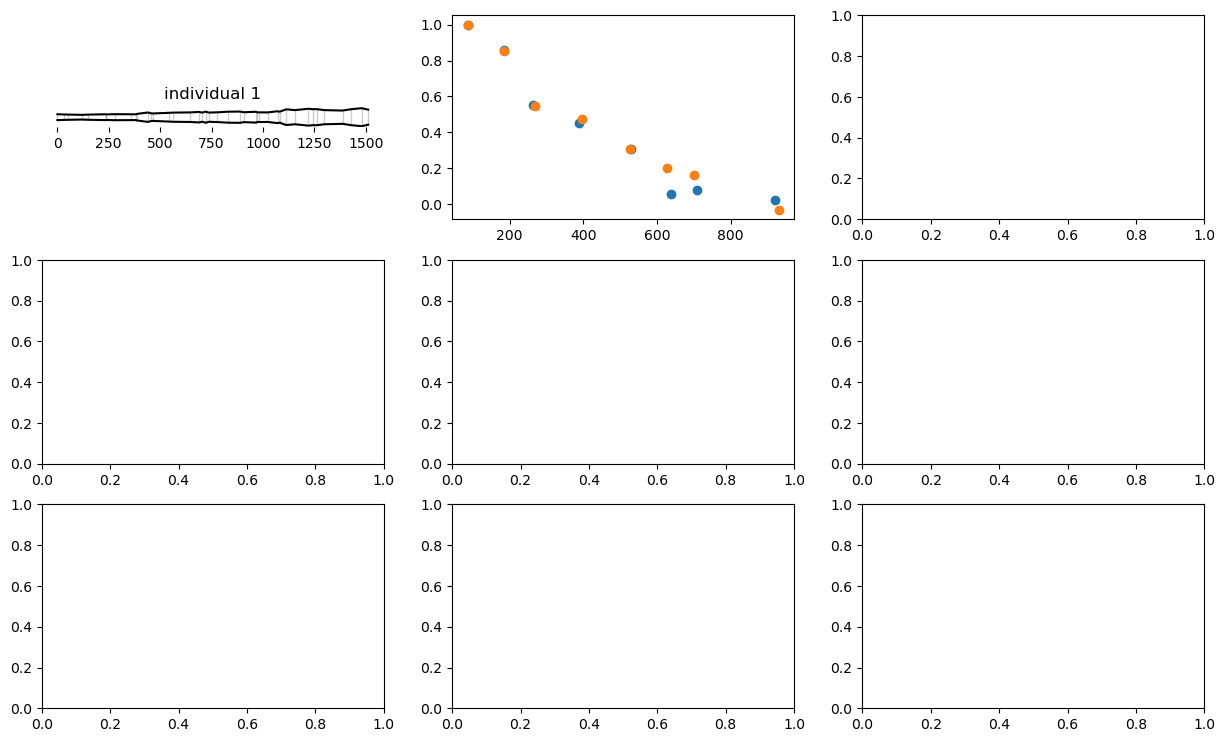

In [2]:
import sys
sys.path.append('../../')
import pickle
import matplotlib.pyplot as plt
import numpy as np

from didgelab.calc.sim.sim import quick_analysis
from didgelab.util.didge_visualizer import plot_geo_to_axs

pop = pickle.load(open("results/pop1.bin", "rb"))
target_freqs, target_impedances, target_weights, geo = pickle.load(open("results/targets.bin", "rb"))
target_freqs = 1000*np.power(2, target_freqs)

def visualize_population(population, n_individuals):
    fix, axs = plt.subplots(nrows=n_individuals, ncols=3, figsize=(15,n_individuals*3))
    for i in range(n_individuals):
        ax = axs[i][0]
        geo = pop[i].genome2geo()
        plot_geo_to_axs(geo, ax)
        ax.set_title(f"individual {i+1}")

        ax = axs[i][1]
        analysis = quick_analysis(geo)

        ax.scatter(analysis["notes"]["freq"], analysis["notes"]["rel_imp"])
        ax.scatter(target_freqs, target_impedances)
        
        ax = axs[i][2]
        text = analysis["notes"][["note_name", "cent_diff", "freq"]].round(2).to_string(index=False)
        l = loss.loss(geo)["total"]
        text += f"\nLoss: {l:.2f}"
        ax.text(0, 0.3, text)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")
        
visualize_population(pop, 3)

In [28]:
population1 = pickle.load(open("results/pop1.bin", "rb"))
target_freqs, target_impedances, target_weights, geo = pickle.load(open("results/targets.bin", "rb"))

target_weights = np.ones(len(target_freqs))
target_weights[0] = 3
loss = TairuaLoss(target_freqs, target_impedances, target_weights)

init_app()

evo = Nuevolution(
    loss, 
    PointShape(geo),
    generation_size = 50,
    num_generations = 100,
    population_size = 100,
    evolution_parameters = {
        "mutation_rate": 0.2,
        "gene_mutation_prob": 0.4,
    },
    initial_population=population1,
    recompute_loss=True
)

schedulers = [
    # LinearDecreasingCrossover(),
    LinearDecreasingMutation()
]

pbi = PrintEvolutionInformation(interval=1)
es = EarlyStopping()

pbar = NuevolutionProgressBar()

max_error = 5
def generation_ended(i_generation, population):
    geo = population[0].genome2geo()
    freqs = get_log_simulation_frequencies(1, 1000, max_error)
    segments = create_segments(geo)
    impedances = compute_impedance(segments, freqs)
    notes = get_notes(freqs, impedances)
    print(notes.round(2))

    l = loss.loss(population[0])
    print(f"loss: {l['total']:.2f}")
    if "individual_losses" in l.keys():
        il = np.array(l["individual_losses"])
        print(il.round(2))

get_app().subscribe("generation_ended", generation_ended)
population2 = evo.evolve()

generation=1, best loss=0.40:   1%|          | 1/100 [00:00<00:00, 76260.07it/s]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.23     1.00
1       F#2      -2.63      -15  184.72      21.54     0.85
2        C3      17.37       -9  264.26      13.93     0.55
3        G3     -17.63       -2  388.02      11.47     0.45
4        C4      17.37        3  528.53       7.84     0.31
5       D#4      42.37        6  637.67       1.49     0.06
6        F4      27.37        8  709.59       2.02     0.08
7       A#5     -22.63       13  920.22       0.59     0.02
loss: 0.40
[0.05 0.   0.02 0.03 0.01 0.14 0.09 0.05]


generation=2, best loss=0.40:   2%|▏         | 2/100 [00:17<14:25,  8.83s/it]   

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.23     1.00
1       F#2      -2.63      -15  184.72      21.57     0.85
2        C3      17.37       -9  264.26      13.93     0.55
3        G3     -17.63       -2  388.02      11.46     0.45
4        C4      17.37        3  528.53       7.83     0.31
5       D#4      42.37        6  637.67       1.49     0.06
6        F4      27.37        8  709.59       2.03     0.08
7       A#5     -22.63       13  920.22       0.59     0.02
loss: 0.40
[0.05 0.   0.02 0.03 0.01 0.14 0.09 0.05]


generation=3, best loss=0.40:   3%|▎         | 3/100 [00:35<20:14, 12.52s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.23     1.00
1       F#2      -2.63      -15  184.72      21.57     0.85
2        C3      17.37       -9  264.26      13.93     0.55
3        G3     -17.63       -2  388.02      11.46     0.45
4        C4      17.37        3  528.53       7.83     0.31
5       D#4      42.37        6  637.67       1.49     0.06
6        F4      27.37        8  709.59       2.03     0.08
7       A#5     -22.63       13  920.22       0.59     0.02
loss: 0.40
[0.05 0.   0.02 0.03 0.01 0.14 0.09 0.05]


generation=4, best loss=0.40:   4%|▍         | 4/100 [00:53<23:09, 14.48s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.27     1.00
1       F#2      -2.63      -15  184.72      21.56     0.85
2        C3      17.37       -9  264.26      13.95     0.55
3        G3     -17.63       -2  388.02      11.46     0.45
4        C4      17.37        3  528.53       7.85     0.31
5       D#4      42.37        6  637.67       1.50     0.06
6        F4      27.37        8  709.59       2.04     0.08
7       A#5     -22.63       13  920.22       0.58     0.02
loss: 0.40
[0.05 0.   0.02 0.03 0.01 0.14 0.09 0.05]


generation=5, best loss=0.40:   5%|▌         | 5/100 [01:09<24:13, 15.30s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.27     1.00
1       F#2      -2.63      -15  184.72      21.56     0.85
2        C3      17.37       -9  264.26      13.95     0.55
3        G3     -17.63       -2  388.02      11.46     0.45
4        C4      17.37        3  528.53       7.85     0.31
5       D#4      42.37        6  637.67       1.50     0.06
6        F4      27.37        8  709.59       2.04     0.08
7       A#5     -22.63       13  920.22       0.58     0.02
loss: 0.40
[0.05 0.   0.02 0.03 0.01 0.14 0.09 0.05]


generation=6, best loss=0.40:   6%|▌         | 6/100 [01:27<25:05, 16.02s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -32.63      -28   85.68      25.27     1.00
1       F#2      -2.63      -15  184.72      21.56     0.85
2        C3      17.37       -9  264.26      13.95     0.55
3        G3     -17.63       -2  388.02      11.46     0.45
4        C4      17.37        3  528.53       7.85     0.31
5       D#4      42.37        6  637.67       1.50     0.06
6        F4      27.37        8  709.59       2.04     0.08
7       A#5     -22.63       13  920.22       0.58     0.02
loss: 0.40
[0.05 0.   0.02 0.03 0.01 0.14 0.09 0.05]


generation=7, best loss=0.39:   7%|▋         | 7/100 [01:44<25:32, 16.47s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      24.97     1.00
1       F#2      -2.63      -15  184.72      21.43     0.86
2        C3      17.37       -9  264.26      14.06     0.56
3        G3     -12.63       -2  389.15      11.37     0.46
4        C4      22.37        3  530.06       7.90     0.32
5       D#4      42.37        6  637.67       1.52     0.06
6        F4      27.37        8  709.59       2.15     0.09
7       A#5     -22.63       13  920.22       0.61     0.02
loss: 0.39
[0.04 0.   0.02 0.03 0.02 0.14 0.08 0.06]


generation=8, best loss=0.39:   8%|▊         | 8/100 [02:02<25:39, 16.73s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      24.97     1.00
1       F#2      -2.63      -15  184.72      21.43     0.86
2        C3      17.37       -9  264.26      14.06     0.56
3        G3     -12.63       -2  389.15      11.37     0.46
4        C4      22.37        3  530.06       7.90     0.32
5       D#4      42.37        6  637.67       1.52     0.06
6        F4      27.37        8  709.59       2.15     0.09
7       A#5     -22.63       13  920.22       0.61     0.02
loss: 0.39
[0.04 0.   0.02 0.03 0.02 0.14 0.08 0.06]


generation=9, best loss=0.39:   9%|▉         | 9/100 [02:20<26:09, 17.25s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      24.97     1.00
1       F#2      -2.63      -15  184.72      21.43     0.86
2        C3      17.37       -9  264.26      14.06     0.56
3        G3     -12.63       -2  389.15      11.37     0.46
4        C4      22.37        3  530.06       7.90     0.32
5       D#4      42.37        6  637.67       1.52     0.06
6        F4      27.37        8  709.59       2.15     0.09
7       A#5     -22.63       13  920.22       0.61     0.02
loss: 0.39
[0.04 0.   0.02 0.03 0.02 0.14 0.08 0.06]


generation=10, best loss=0.39:  10%|█         | 10/100 [02:37<25:36, 17.07s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      24.97     1.00
1       F#2      -2.63      -15  184.72      21.43     0.86
2        C3      17.37       -9  264.26      14.06     0.56
3        G3     -12.63       -2  389.15      11.37     0.46
4        C4      22.37        3  530.06       7.90     0.32
5       D#4      42.37        6  637.67       1.52     0.06
6        F4      27.37        8  709.59       2.15     0.09
7       A#5     -22.63       13  920.22       0.61     0.02
loss: 0.39
[0.04 0.   0.02 0.03 0.02 0.14 0.08 0.06]


generation=11, best loss=0.39:  11%|█         | 11/100 [02:54<25:37, 17.28s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      24.97     1.00
1       F#2      -2.63      -15  184.72      21.43     0.86
2        C3      17.37       -9  264.26      14.06     0.56
3        G3     -12.63       -2  389.15      11.37     0.46
4        C4      22.37        3  530.06       7.90     0.32
5       D#4      42.37        6  637.67       1.52     0.06
6        F4      27.37        8  709.59       2.15     0.09
7       A#5     -22.63       13  920.22       0.61     0.02
loss: 0.39
[0.04 0.   0.02 0.03 0.02 0.14 0.08 0.06]


generation=12, best loss=0.39:  12%|█▏        | 12/100 [03:12<25:17, 17.24s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      24.97     1.00
1       F#2      -2.63      -15  184.72      21.43     0.86
2        C3      17.37       -9  264.26      14.06     0.56
3        G3     -12.63       -2  389.15      11.37     0.46
4        C4      22.37        3  530.06       7.90     0.32
5       D#4      42.37        6  637.67       1.52     0.06
6        F4      27.37        8  709.59       2.15     0.09
7       A#5     -22.63       13  920.22       0.61     0.02
loss: 0.39
[0.04 0.   0.02 0.03 0.02 0.14 0.08 0.06]


generation=13, best loss=0.39:  13%|█▎        | 13/100 [03:29<25:01, 17.26s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      24.99     1.00
1       F#2      -2.63      -15  184.72      21.41     0.86
2        C3      17.37       -9  264.26      14.05     0.56
3        G3     -12.63       -2  389.15      11.37     0.46
4        C4      22.37        3  530.06       7.89     0.32
5       D#4      42.37        6  637.67       1.52     0.06
6        F4      27.37        8  709.59       2.16     0.09
7       A#5     -22.63       13  920.22       0.61     0.02
loss: 0.39
[0.04 0.   0.02 0.03 0.02 0.14 0.08 0.06]


generation=14, best loss=0.39:  14%|█▍        | 14/100 [03:47<25:06, 17.52s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      24.99     1.00
1       F#2      -2.63      -15  184.72      21.41     0.86
2        C3      17.37       -9  264.26      14.05     0.56
3        G3     -12.63       -2  389.15      11.37     0.46
4        C4      22.37        3  530.06       7.89     0.32
5       D#4      42.37        6  637.67       1.52     0.06
6        F4      27.37        8  709.59       2.16     0.09
7       A#5     -22.63       13  920.22       0.61     0.02
loss: 0.39
[0.04 0.   0.02 0.03 0.02 0.14 0.08 0.06]


generation=15, best loss=0.38:  15%|█▌        | 15/100 [04:04<24:34, 17.35s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.04     1.00
1       F#2       2.37      -15  185.25      21.41     0.86
2        C3      22.37       -9  265.03      14.17     0.57
3        G3     -12.63       -2  389.15      11.68     0.47
4        C4      22.37        3  530.06       8.02     0.32
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.17     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.02 0.03 0.02 0.14 0.08 0.06]


generation=16, best loss=0.38:  16%|█▌        | 16/100 [04:21<24:16, 17.34s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.04     1.00
1       F#2       2.37      -15  185.25      21.41     0.86
2        C3      22.37       -9  265.03      14.17     0.57
3        G3     -12.63       -2  389.15      11.68     0.47
4        C4      22.37        3  530.06       8.02     0.32
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.17     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.02 0.03 0.02 0.14 0.08 0.06]


generation=17, best loss=0.38:  17%|█▋        | 17/100 [04:39<24:11, 17.49s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.34     1.00
1       F#2      -2.63      -15  184.72      21.41     0.85
2        C3      22.37       -9  265.03      13.98     0.55
3        G3     -17.63       -2  388.02      11.74     0.46
4        C4      22.37        3  530.06       7.60     0.30
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5     -17.63       13  922.88       0.64     0.03
loss: 0.38
[0.04 0.01 0.01 0.03 0.01 0.14 0.08 0.06]


generation=18, best loss=0.38:  18%|█▊        | 18/100 [04:57<23:59, 17.55s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.19     1.00
1       F#2      -2.63      -15  184.72      21.47     0.85
2        C3      22.37       -9  265.03      13.98     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=19, best loss=0.38:  19%|█▉        | 19/100 [05:14<23:23, 17.33s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.19     1.00
1       F#2      -2.63      -15  184.72      21.47     0.85
2        C3      22.37       -9  265.03      13.98     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=20, best loss=0.38:  20%|██        | 20/100 [05:31<22:54, 17.19s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.20     1.00
1       F#2      -2.63      -15  184.72      21.47     0.85
2        C3      22.37       -9  265.03      13.98     0.55
3        G3     -17.63       -2  388.02      11.53     0.46
4        C4      22.37        3  530.06       7.75     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=21, best loss=0.38:  21%|██        | 21/100 [05:48<22:38, 17.19s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.95     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=22, best loss=0.38:  22%|██▏       | 22/100 [06:05<22:33, 17.36s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.95     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=23, best loss=0.38:  23%|██▎       | 23/100 [06:24<22:41, 17.69s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.47     0.85
2        C3      22.37       -9  265.03      13.94     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=24, best loss=0.38:  24%|██▍       | 24/100 [06:42<22:22, 17.66s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.47     0.85
2        C3      22.37       -9  265.03      13.94     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=25, best loss=0.38:  25%|██▌       | 25/100 [06:59<21:59, 17.59s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.47     0.85
2        C3      22.37       -9  265.03      13.94     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=26, best loss=0.38:  26%|██▌       | 26/100 [07:53<35:02, 28.41s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.47     0.85
2        C3      22.37       -9  265.03      13.94     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=27, best loss=0.38:  27%|██▋       | 27/100 [08:11<30:48, 25.33s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.47     0.85
2        C3      22.37       -9  265.03      13.94     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=28, best loss=0.38:  28%|██▊       | 28/100 [08:29<27:50, 23.21s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.47     0.85
2        C3      22.37       -9  265.03      13.94     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=29, best loss=0.38:  29%|██▉       | 29/100 [08:47<25:40, 21.69s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.47     0.85
2        C3      22.37       -9  265.03      13.94     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=30, best loss=0.38:  30%|███       | 30/100 [09:05<23:54, 20.50s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.47     0.85
2        C3      22.37       -9  265.03      13.94     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=31, best loss=0.38:  31%|███       | 31/100 [09:22<22:33, 19.62s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.47     0.85
2        C3      22.37       -9  265.03      13.94     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.13     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=32, best loss=0.38:  32%|███▏      | 32/100 [09:40<21:42, 19.15s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.95     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=33, best loss=0.38:  33%|███▎      | 33/100 [09:59<21:01, 18.82s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.72     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=34, best loss=0.38:  34%|███▍      | 34/100 [10:17<20:30, 18.64s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.72     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=35, best loss=0.38:  35%|███▌      | 35/100 [10:36<20:16, 18.72s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.72     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=36, best loss=0.38:  36%|███▌      | 36/100 [10:54<19:46, 18.54s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.72     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=37, best loss=0.38:  37%|███▋      | 37/100 [11:13<19:39, 18.72s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.72     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=38, best loss=0.38:  38%|███▊      | 38/100 [11:32<19:18, 18.69s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=39, best loss=0.38:  39%|███▉      | 39/100 [11:50<18:57, 18.65s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=40, best loss=0.38:  40%|████      | 40/100 [12:08<18:27, 18.45s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=41, best loss=0.38:  41%|████      | 41/100 [12:26<18:05, 18.40s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.63     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=42, best loss=0.38:  42%|████▏     | 42/100 [12:45<17:51, 18.47s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.63     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=43, best loss=0.38:  43%|████▎     | 43/100 [13:04<17:42, 18.64s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.94     0.55
3        G3     -17.63       -2  388.02      11.53     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=44, best loss=0.38:  44%|████▍     | 44/100 [13:23<17:22, 18.61s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.17     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.94     0.55
3        G3     -17.63       -2  388.02      11.54     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.08
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=45, best loss=0.38:  45%|████▌     | 45/100 [13:40<16:46, 18.30s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.53     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=46, best loss=0.38:  46%|████▌     | 46/100 [13:58<16:18, 18.13s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=47, best loss=0.38:  47%|████▋     | 47/100 [14:16<16:01, 18.14s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=48, best loss=0.38:  48%|████▊     | 48/100 [14:34<15:41, 18.10s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.63     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=49, best loss=0.38:  49%|████▉     | 49/100 [14:52<15:17, 17.98s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.63     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=50, best loss=0.38:  50%|█████     | 50/100 [15:10<14:57, 17.96s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.57     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=51, best loss=0.38:  51%|█████     | 51/100 [16:03<23:26, 28.70s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.57     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=52, best loss=0.38:  52%|█████▏    | 52/100 [16:22<20:25, 25.54s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.57     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=53, best loss=0.38:  53%|█████▎    | 53/100 [16:41<18:33, 23.68s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.57     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=54, best loss=0.38:  54%|█████▍    | 54/100 [16:59<16:58, 22.14s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.57     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=55, best loss=0.38:  55%|█████▌    | 55/100 [17:20<16:12, 21.61s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.57     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=56, best loss=0.38:  56%|█████▌    | 56/100 [17:40<15:27, 21.08s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.53     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=57, best loss=0.38:  57%|█████▋    | 57/100 [17:58<14:36, 20.39s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.53     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=58, best loss=0.38:  58%|█████▊    | 58/100 [18:20<14:25, 20.61s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.57     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.63     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=59, best loss=0.38:  59%|█████▉    | 59/100 [18:40<14:03, 20.56s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.57     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.63     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=60, best loss=0.38:  60%|██████    | 60/100 [19:01<13:48, 20.71s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=61, best loss=0.38:  61%|██████    | 61/100 [19:22<13:33, 20.87s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.92     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=62, best loss=0.38:  62%|██████▏   | 62/100 [19:43<13:13, 20.88s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.92     0.55
3        G3     -17.63       -2  388.02      11.52     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.56     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=63, best loss=0.38:  63%|██████▎   | 63/100 [20:04<12:55, 20.97s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.53     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.57     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=64, best loss=0.38:  64%|██████▍   | 64/100 [20:26<12:44, 21.25s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.53     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.57     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=65, best loss=0.38:  65%|██████▌   | 65/100 [20:45<12:01, 20.62s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.53     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.57     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=66, best loss=0.38:  66%|██████▌   | 66/100 [21:04<11:20, 20.01s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.16     1.00
1       F#2      -2.63      -15  184.72      21.48     0.85
2        C3      22.37       -9  265.03      13.93     0.55
3        G3     -17.63       -2  388.02      11.53     0.46
4        C4      22.37        3  530.06       7.73     0.31
5       D#4      42.37        6  637.67       1.57     0.06
6        F4      27.37        8  709.59       2.14     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.38
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=67, best loss=0.37:  67%|██████▋   | 67/100 [21:23<10:44, 19.54s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=68, best loss=0.37:  68%|██████▊   | 68/100 [21:41<10:12, 19.15s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=69, best loss=0.37:  69%|██████▉   | 69/100 [21:59<09:47, 18.95s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=70, best loss=0.37:  70%|███████   | 70/100 [22:17<09:21, 18.73s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=71, best loss=0.37:  71%|███████   | 71/100 [22:36<08:59, 18.62s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=72, best loss=0.37:  72%|███████▏  | 72/100 [22:54<08:39, 18.55s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=73, best loss=0.37:  73%|███████▎  | 73/100 [23:13<08:19, 18.48s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=74, best loss=0.37:  74%|███████▍  | 74/100 [23:31<07:59, 18.43s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=75, best loss=0.37:  75%|███████▌  | 75/100 [23:49<07:40, 18.41s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=76, best loss=0.37:  76%|███████▌  | 76/100 [24:43<11:37, 29.07s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=77, best loss=0.37:  77%|███████▋  | 77/100 [25:02<09:55, 25.91s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=78, best loss=0.37:  78%|███████▊  | 78/100 [25:21<08:43, 23.78s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=79, best loss=0.37:  79%|███████▉  | 79/100 [25:39<07:47, 22.27s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=80, best loss=0.37:  80%|████████  | 80/100 [25:58<07:03, 21.16s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=81, best loss=0.37:  81%|████████  | 81/100 [26:17<06:27, 20.42s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=82, best loss=0.37:  82%|████████▏ | 82/100 [26:35<05:57, 19.85s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=83, best loss=0.37:  83%|████████▎ | 83/100 [26:54<05:31, 19.49s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=84, best loss=0.37:  84%|████████▍ | 84/100 [27:12<05:06, 19.17s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.01     1.00
1       F#2      -2.63      -15  184.72      21.39     0.86
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.44     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.61     0.06
6        F4      27.37        8  709.59       2.19     0.09
7       A#5     -22.63       13  920.22       0.63     0.03
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=85, best loss=0.37:  85%|████████▌ | 85/100 [27:31<04:44, 18.96s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.12     1.00
1       F#2      -2.63      -15  184.72      21.38     0.85
2        C3      22.37       -9  265.03      13.74     0.55
3        G3     -12.63       -2  389.15      11.54     0.46
4        C4      22.37        3  530.06       7.77     0.31
5       D#4      42.37        6  637.67       1.59     0.06
6        F4      27.37        8  709.59       2.21     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=86, best loss=0.37:  86%|████████▌ | 86/100 [27:49<04:24, 18.86s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.07     1.00
1       F#2      -2.63      -15  184.72      21.39     0.85
2        C3      22.37       -9  265.03      13.77     0.55
3        G3     -12.63       -2  389.15      11.49     0.46
4        C4      22.37        3  530.06       7.76     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.20     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=87, best loss=0.37:  87%|████████▋ | 87/100 [28:08<04:03, 18.75s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.07     1.00
1       F#2      -2.63      -15  184.72      21.39     0.85
2        C3      22.37       -9  265.03      13.77     0.55
3        G3     -12.63       -2  389.15      11.49     0.46
4        C4      22.37        3  530.06       7.76     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.20     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=88, best loss=0.37:  88%|████████▊ | 88/100 [28:27<03:45, 18.82s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.07     1.00
1       F#2      -2.63      -15  184.72      21.39     0.85
2        C3      22.37       -9  265.03      13.77     0.55
3        G3     -12.63       -2  389.15      11.49     0.46
4        C4      22.37        3  530.06       7.76     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.20     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=89, best loss=0.37:  89%|████████▉ | 89/100 [28:45<03:26, 18.74s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.07     1.00
1       F#2      -2.63      -15  184.72      21.39     0.85
2        C3      22.37       -9  265.03      13.77     0.55
3        G3     -12.63       -2  389.15      11.49     0.46
4        C4      22.37        3  530.06       7.76     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.20     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=90, best loss=0.37:  90%|█████████ | 90/100 [29:04<03:07, 18.73s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.07     1.00
1       F#2      -2.63      -15  184.72      21.39     0.85
2        C3      22.37       -9  265.03      13.77     0.55
3        G3     -12.63       -2  389.15      11.49     0.46
4        C4      22.37        3  530.06       7.76     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.20     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=91, best loss=0.37:  91%|█████████ | 91/100 [29:23<02:49, 18.79s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.07     1.00
1       F#2      -2.63      -15  184.72      21.39     0.85
2        C3      22.37       -9  265.03      13.77     0.55
3        G3     -12.63       -2  389.15      11.49     0.46
4        C4      22.37        3  530.06       7.76     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.20     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=92, best loss=0.37:  92%|█████████▏| 92/100 [29:43<02:34, 19.29s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.07     1.00
1       F#2      -2.63      -15  184.72      21.39     0.85
2        C3      22.37       -9  265.03      13.77     0.55
3        G3     -12.63       -2  389.15      11.49     0.46
4        C4      22.37        3  530.06       7.76     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.20     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=93, best loss=0.37:  93%|█████████▎| 93/100 [30:04<02:18, 19.75s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.07     1.00
1       F#2      -2.63      -15  184.72      21.39     0.85
2        C3      22.37       -9  265.03      13.77     0.55
3        G3     -12.63       -2  389.15      11.49     0.46
4        C4      22.37        3  530.06       7.76     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.20     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=94, best loss=0.37:  94%|█████████▍| 94/100 [30:23<01:56, 19.36s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.07     1.00
1       F#2      -2.63      -15  184.72      21.39     0.85
2        C3      22.37       -9  265.03      13.77     0.55
3        G3     -12.63       -2  389.15      11.49     0.46
4        C4      22.37        3  530.06       7.76     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.20     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=95, best loss=0.37:  95%|█████████▌| 95/100 [30:42<01:36, 19.39s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.07     1.00
1       F#2      -2.63      -15  184.72      21.39     0.85
2        C3      22.37       -9  265.03      13.77     0.55
3        G3     -12.63       -2  389.15      11.49     0.46
4        C4      22.37        3  530.06       7.76     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.20     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=96, best loss=0.37:  96%|█████████▌| 96/100 [31:01<01:17, 19.32s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.06     1.00
1       F#2      -2.63      -15  184.72      21.38     0.85
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.50     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.21     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=97, best loss=0.37:  97%|█████████▋| 97/100 [31:20<00:57, 19.09s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.06     1.00
1       F#2      -2.63      -15  184.72      21.38     0.85
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.50     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.21     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=98, best loss=0.37:  98%|█████████▊| 98/100 [31:39<00:38, 19.12s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.06     1.00
1       F#2      -2.63      -15  184.72      21.38     0.85
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.50     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.21     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=99, best loss=0.37:  99%|█████████▉| 99/100 [31:58<00:18, 18.97s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.06     1.00
1       F#2      -2.63      -15  184.72      21.38     0.85
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.50     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.21     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


generation=100, best loss=0.37: 100%|██████████| 100/100 [32:17<00:00, 18.96s/it]

  note_name  cent_diff  note_nr    freq  impedance  rel_imp
0        F1     -27.63      -28   85.92      25.06     1.00
1       F#2      -2.63      -15  184.72      21.38     0.85
2        C3      22.37       -9  265.03      13.80     0.55
3        G3     -12.63       -2  389.15      11.50     0.46
4        C4      22.37        3  530.06       7.74     0.31
5       D#4      42.37        6  637.67       1.60     0.06
6        F4      27.37        8  709.59       2.21     0.09
7       A#5     -22.63       13  920.22       0.62     0.02
loss: 0.37
[0.04 0.   0.01 0.03 0.01 0.14 0.08 0.06]


In [29]:
pickle.dump(population2, open("results/pop2.bin", "wb"))

In [32]:
pop2 = pickle.load(open("results/pop2.bin", "rb"))
target_freqs, target_impedances, target_weights, geo = pickle.load(open("results/targets.bin", "rb"))

target_weights = np.ones(len(target_freqs))
target_weights[0] = 5
loss = TairuaLoss(target_freqs, target_impedances, target_weights)

def run_evolution(evo : Nuevolution):
    
    init_app()
    schedulers = [
        # LinearDecreasingCrossover(),
        LinearDecreasingMutation()
    ]

    pbi = PrintEvolutionInformation(interval=1)
    es = EarlyStopping()

    pbar = NuevolutionProgressBar()

    max_error = 5
    def generation_ended(i_generation, population):
        geo = population[0].genome2geo()
        freqs = get_log_simulation_frequencies(1, 1000, max_error)
        segments = create_segments(geo)
        impedances = compute_impedance(segments, freqs)
        notes = get_notes(freqs, impedances)
        print(notes.round(2))

        l = loss.loss(population[0])
        print(f"loss: {l['total']:.2f}")
        if "individual_losses" in l.keys():
            il = np.array(l["individual_losses"])
            print(il.round(2))

    get_app().subscribe("generation_ended", generation_ended)
    return evo.evolve()    

evo = Nuevolution(
    loss, 
    PointShape(geo),
    generation_size = 50,
    num_generations = 100,
    population_size = 500,
    evolution_parameters = {
        "mutation_rate": 0.2,
        "gene_mutation_prob": 0.4,
    },
    initial_population=population1,
    recompute_loss=True
)
pop3 = run_evolution(evo)

100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


AttributeError: 'NoneType' object has no attribute 'get_evolution_progress'

In [14]:
import pickle
import sys
import numpy as np

sys.path.append('../../')

from didgelab.calc.geo import Geo
from didgelab.app import init_app
from tairua import TairuaLoss, PointShape
from didgelab.calc.sim.sim import get_notes, compute_impedance, create_segments, get_log_simulation_frequencies
from didgelab.evo.nuevolution import Nuevolution, LinearParameterDecrease, PrintEvolutionInformation, \
    EarlyStopping, NuevolutionProgressBar, AdaptiveProbabilities
from didgelab.app import get_app

pop2 = pickle.load(open("results/pop2.bin", "rb"))
target_freqs, target_impedances, geo = pickle.load(open("results/targets.bin", "rb"))

target_weights = np.ones(len(target_freqs))
target_weights[0] = 10
loss = TairuaLoss(target_freqs, target_impedances, target_weights)

init_app()

evo = Nuevolution(
    loss, 
    PointShape(geo),
    generation_size = 50,
    num_generations = 100,
    population_size = 500,
    evolution_parameters = {
        "mutation_rate": 0.3,
        "gene_mutation_prob": 0.4,
    },
    disable_crossover=True,
    initial_population=pop2,
    recompute_loss=True
)

schedulers = [
    LinearParameterDecrease(0.3, 0.1, "mutation_rate"),
    LinearParameterDecrease(0.4, 0.1, "mutatgene_mutation_probion_rate"),
]

pbi = PrintEvolutionInformation(interval=1)
es = EarlyStopping()

ap = AdaptiveProbabilities()
pbar = NuevolutionProgressBar()

max_error = 5
def generation_ended(i_generation, population):
    geo = population[0].genome2geo()
    freqs = get_log_simulation_frequencies(1, 1000, max_error)
    segments = create_segments(geo)
    impedances = compute_impedance(segments, freqs)
    notes = get_notes(freqs, impedances)
    print(notes.round(2))

    l = loss.loss(population[0])
    print(f"loss: {l['total']:.2f}")
    if "individual_losses" in l.keys():
        il = np.array(l["individual_losses"])
        print(il.round(2))

get_app().subscribe("generation_ended", generation_ended)
pop3 = evo.evolve()    

2025-04-28 15:38:21,867 [INFO] {app.py:51} output folder: /opt/miniconda3/envs/didge/lib/python3.8/site-packages/didgelab/../../evolutions/2025-04-28T15-38-21_jupyter
2025-04-28 15:38:21,868 [INFO] {app.py:57} Configuration:
log_level: info
2025-04-28 15:38:21,869 [INFO] {app.py:141} 
 _____  _     _              _           _     
|  __ \(_)   | |            | |         | |    
| |  | |_  __| | __ _  ___  | |     __ _| |__  
| |  | | |/ _` |/ _` |/ _ \ | |    / _` | '_ \ 
| |__| | | (_| | (_| |  __/ | |___| (_| | |_) |
|_____/|_|\__,_|\__, |\___| |______\__,_|_.__/ 
                 __/ |                         
                |___/                          
Starting /opt/miniconda3/envs/didge/lib/python3.8/site-packages/ipykernel_launcher.py --f=/Users/jannehring/Library/Jupyter/runtime/kernel-v3a8c704fcdbddd15debdeb7db314e435a61e7d0d7.json
2025-04-28 15:38:21,870 [INFO] {nuevolution.py:488} Initialize Nuevolution
evolution_operator_probs: [0.16666666666666666, 0.16666666666666666,

KeyboardInterrupt: 

In [1]:
pickle.dump(pop3, open("results/pop3.bin", "wb"))

NameError: name 'pickle' is not defined